# **Banking Beyond Transactions: AI-Driven Churn Propensity Modeling**

## Problem Statement:
- Customer churn is a significant issue for banks, impacting revenue and customer lifetime value. The goal is to develop a machine learning model that predicts whether a customer will churn (leave the bank) based on their demographic, financial, and account activity data.

## Objective:
- Build a predictive model to classify customers as likely to churn (Exited = 1) or stay (Exited = 0).
- Identify key factors influencing customer attrition.
- Provide actionable insights for customer retention strategies.

**Data Dictionary:**

The dataset consists of 10,000 records with 13 features:
1. **CustomerId**: Unique identifier for each customer.
2. **Lastname**: Customer's last name (not useful for prediction).
3. **CreditScore**: Customer's credit rating.
4. **Geography**: Country of the customer (France, Spain, Germany).
5. **Gender**: Male or Female.
6. **Age**: Customer's age.
7. **Tenure**: Number of years the customer has been with the bank.
8. **Balance**: Account balance.
9. **NumOfProducts**: Number of products the customer has with the bank.
10. **HasCrCard**: Whether the customer has a credit card (1 = Yes, 0 = No).
11. **IsActiveMember**: Whether the customer is an active member (1 = Yes, 0 = No).
12. **EstimatedSalary**: Customer's estimated salary.
13. **Exited**: Target variable (1 = Churned, 0 = Stayed).

# Predictive Model
- Our aim is to build a predictive model that correctly predicts the customers that may churn (i.e. True Positives). Along with maximizing the True Positives, our focus is to minimize False Negatives (i.e. missing customers that are likely to churn), as it may impact the revenue of the Bank, as well as monitor False Positives (i.e. misclassifying retained customers) that allows Bank to fairly allocate resources.
- That is, for the positive class cases, high Recall is the requirement.

**Steps:**
1. Data Collection
2. Data Wrangling/Cleaning
3. Exploratory Data Analysis
4. Data Preprocessing
5. Model Developement
6. Model Evaluation

## 1. Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.stats as stats

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, precision_recall_curve

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## 2. Load Data

In [3]:
project_dir = r"C:\Users\anike\DATA SCIENCE AND AI\ML Projects"
file_dir = "Bank Churn Prediction"

def load_data(filename, format = 'csv', sheet = 0):
    file_name = f'{filename}.{format}'
    file_path = os.path.join(project_dir, file_dir, file_name)
    if format == 'csv':
        return pd.read_csv(file_path)
    elif format == 'xlsx':
        return pd.read_excel(file_path, sheet_name = sheet)
    else:
        print(f'Unsupported file format: {format}')
        return None

In [4]:
data1 = load_data('Bank_Churn_Messy', format = 'xlsx', sheet = 0)
data2 = load_data('Bank_Churn_Messy', format = 'xlsx', sheet = 1)
data_dict = load_data('Bank_Churn_Data_Dictionary', format = 'csv')
print('Data Loaded')

Data Loaded


In [5]:
data_dict

,Field,Description
0,CustomerId,A unique identifier for each customer
1,Surname,The customer's last name
2,CreditScore,A numerical value representing the customer's credit score
3,Geography,"The country where the customer resides (France, Spain or Germany)"
4,Gender,The customer's gender (Male or Female)
5,Age,The customer's age
6,Tenure,The number of years the customer has been with the bank
7,Balance,The customer's account balance
8,NumOfProducts,"The number of bank products the customer uses (e.g., savings account, credit card)"
9,HasCrCard,"Whether the customer has a credit card (1 = yes, 0 = no)"


In [6]:
print(f"Data1:\nNumber of entries: {data1.shape[0]}")
print(f"Number of features - {data1.shape[1]}\n")

print(f"Data2:\nNumber of entries - {data2.shape[0]}")
print(f"Number of features - {data2.shape[1]}")

Data1:
Number of entries: 10001
Number of features - 8

Data2:
Number of entries - 10002
Number of features - 7


In [7]:
data1.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,EstimatedSalary
0,15634602,Hargrave,619,FRA,Female,42.0,2,€101348.88
1,15647311,Hill,608,Spain,Female,41.0,1,€112542.58
2,15619304,Onio,502,French,Female,42.0,8,€113931.57
3,15701354,Boni,699,FRA,Female,39.0,1,€93826.63
4,15737888,Mitchell,850,Spain,Female,43.0,2,€79084.1


In [8]:
data2.head()

,CustomerId,Balance,NumOfProducts,HasCrCard,Tenure,IsActiveMember,Exited
0,15634602,€0.0,1,Yes,2,Yes,1
1,15634602,€0.0,1,Yes,2,Yes,1
2,15647311,€83807.86,1,Yes,1,Yes,0
3,15619304,€159660.8,3,No,8,No,1
4,15701354,€0.0,2,No,1,No,0


In [9]:
data1.sort_values(by = ['CustomerId'], ignore_index = True, inplace = True)
display(data1)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,EstimatedSalary
0,15565701,Ferri,698,Spain,Female,39.0,9,€90212.38
1,15565706,Akobundu,612,Spain,Male,35.0,1,€83256.26
2,15565714,Cattaneo,601,France,Male,47.0,1,€96517.97
3,15565779,Kent,627,Germany,Female,30.0,6,€188258.49
4,15565796,Docherty,745,Germany,Male,48.0,10,€74510.65
...,...,...,...,...,...,...,...,...
9996,15815628,Moysey,711,France,Female,37.0,8,€80215.2
9997,15815645,Akhtar,481,FRA,Male,37.0,8,€175082.2
9998,15815656,Hopkins,541,Germany,Female,39.0,9,€199808.1
9999,15815660,Mazzi,758,FRA,Female,34.0,1,€60728.89


In [10]:
data2.sort_values(by = ['CustomerId'], ignore_index = True, inplace = True)
display(data2)

,CustomerId,Balance,NumOfProducts,HasCrCard,Tenure,IsActiveMember,Exited
0,15565701,€161993.89,1,No,9,No,0
1,15565706,€0.0,1,Yes,1,Yes,1
2,15565714,€64430.06,2,Yes,1,Yes,0
3,15565779,€57809.32,1,No,6,No,0
4,15565796,€96048.55,1,No,10,No,0
...,...,...,...,...,...,...,...
9997,15815628,€113899.92,1,No,8,No,0
9998,15815645,€152303.66,2,Yes,8,Yes,0
9999,15815656,€100116.67,1,Yes,9,Yes,1
10000,15815660,€154139.45,1,Yes,1,Yes,0


**2. Observations**
- As per Data Dictionary, there are 13 attributes in the data containing 12 Features and 1 Dependent Variable ('Exited').
- Data is split into 2 tables (data1 & data2) with 'CustomerId' & 'Tenure' as common features.
- Datasets data1 & data2 to be merged on common features 'CustomerId' & 'Tenure' to get the desired dataset for our analysis.

# 3. Overview of the Data
## 3.1. General Overview

In [11]:
data = pd.merge(left = data1, right = data2, how = 'inner', on = ['CustomerId', 'Tenure'])

print(f"Number of entries in the data: {data.shape[0]}")
print(f"Number of features in the data: {data.shape[1]}")

Number of entries in the data: 10004
Number of features in the data: 13


In [12]:
data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,EstimatedSalary,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited
0,15565701,Ferri,698,Spain,Female,39.0,9,€90212.38,€161993.89,1,No,No,0
1,15565706,Akobundu,612,Spain,Male,35.0,1,€83256.26,€0.0,1,Yes,Yes,1
2,15565714,Cattaneo,601,France,Male,47.0,1,€96517.97,€64430.06,2,Yes,Yes,0
3,15565779,Kent,627,Germany,Female,30.0,6,€188258.49,€57809.32,1,No,No,0
4,15565796,Docherty,745,Germany,Male,48.0,10,€74510.65,€96048.55,1,No,No,0


In [13]:
data.tail()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,EstimatedSalary,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited
9999,15815628,Moysey,711,France,Female,37.0,8,€80215.2,€113899.92,1,No,No,0
10000,15815645,Akhtar,481,FRA,Male,37.0,8,€175082.2,€152303.66,2,Yes,Yes,0
10001,15815656,Hopkins,541,Germany,Female,39.0,9,€199808.1,€100116.67,1,Yes,Yes,1
10002,15815660,Mazzi,758,FRA,Female,34.0,1,€60728.89,€154139.45,1,Yes,Yes,0
10003,15815690,Akabueze,614,Spain,Female,40.0,3,€77789.01,€113348.5,1,Yes,Yes,0


## 3.2. Overview - Name & Datatype

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10004 entries, 0 to 10003
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10004 non-null  int64  
 1   Surname          10001 non-null  object 
 2   CreditScore      10004 non-null  int64  
 3   Geography        10004 non-null  object 
 4   Gender           10004 non-null  object 
 5   Age              10001 non-null  float64
 6   Tenure           10004 non-null  int64  
 7   EstimatedSalary  10004 non-null  object 
 8   Balance          10004 non-null  object 
 9   NumOfProducts    10004 non-null  int64  
 10  HasCrCard        10004 non-null  object 
 11  IsActiveMember   10004 non-null  object 
 12  Exited           10004 non-null  int64  
dtypes: float64(1), int64(5), object(7)
memory usage: 1016.2+ KB


## 3.2. Observations
- Data contains 10004 entries/rows and 13 features/columns.
- There are 7 features of 'object' type, 5 features of 'int' type and 1 feature of 'float' datatype.
- Datatypes of 'EstimatedSalary' and 'Balance' features to be changed to 'float' after analyzing them in the next sections.
- There are missing values in the 'Surname' and 'Age' feature which will be analyzed in the further section.

## 3.3. Check for Duplicate Entries

In [15]:
if data.duplicated().sum() > 0:
    print(f'There are {data.duplicated().sum()} duplicate entries/rows in the data')
else:
    print('There are no duplicate entries/rows in the data')

There are 4 duplicate entries/rows in the data


In [16]:
data[data.duplicated(keep = False)]

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,EstimatedSalary,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited
2497,15628319,Walker,792,French,Female,28.0,4,€38190.78,€130142.79,1,No,No,0
2498,15628319,Walker,792,French,Female,28.0,4,€38190.78,€130142.79,1,No,No,0
2499,15628319,Walker,792,French,Female,28.0,4,€38190.78,€130142.79,1,No,No,0
2500,15628319,Walker,792,French,Female,28.0,4,€38190.78,€130142.79,1,No,No,0
2739,15634602,Hargrave,619,FRA,Female,42.0,2,€101348.88,€0.0,1,Yes,Yes,1
2740,15634602,Hargrave,619,FRA,Female,42.0,2,€101348.88,€0.0,1,Yes,Yes,1


In [17]:
(
    data[
    data
    .duplicated(keep = False)
    ]
    .isnull()
    .sum()
)

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
EstimatedSalary    0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
Exited             0
dtype: int64

**3.3. Observations**
- There are 4 duplicate entries/rows in the data.
- Data pertaining to customer id '15634602' is duplicated once and for customer id '15628319' it is duplicated thrice.
- Also there are no missing values in these duplicate entries. So we can analyse missing values of the dataset independently.
- Duplicated rows to be dropped by keeping the first/original instance.

## 3.4. Check for Missing values

In [18]:
def check_missing_values(data):
    flag = 0
    
    missing_values = []
    col_names = []
    mv_percentage = []
    print('Missing Values:\n')
    
    for col in data.columns:
        if data[col].isnull().sum() > 0:
            flag = 1
            missing_values.append(data[col].isnull().sum())
            mv_percentage.append(round(data[col].isnull().sum()*100/data.shape[0],2))
            col_names.append(col)
    else:
        if flag == 0:
            print('There are no missing values in the data.')
            
    mv_df = pd.DataFrame(data = {'values': missing_values, 
                                 'percentage': mv_percentage},
                         index = col_names)
    mv_df = mv_df.rename_axis(index = 'feature')
    mv_df = mv_df.sort_values(by = 'values', ascending = False)
    display(mv_df)

In [19]:
check_missing_values(data)

Missing Values:



,values,percentage
feature,,
Surname,3,0.03
Age,3,0.03


In [20]:
data[data['Surname'].isna()]

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,EstimatedSalary,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited
557,15580203,NaN,674,Spain,Male,NaN,6,-€999999,€120193.42,1,No,No,0
6536,15728693,NaN,574,Germany,Female,NaN,3,-€999999,€141349.43,1,Yes,Yes,0
7643,15756954,NaN,538,France,Female,NaN,2,-€999999,€0.0,1,Yes,Yes,0


In [21]:
data[data['Age'].isna()]

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,EstimatedSalary,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited
557,15580203,NaN,674,Spain,Male,NaN,6,-€999999,€120193.42,1,No,No,0
6536,15728693,NaN,574,Germany,Female,NaN,3,-€999999,€141349.43,1,Yes,Yes,0
7643,15756954,NaN,538,France,Female,NaN,2,-€999999,€0.0,1,Yes,Yes,0


In [22]:
data[data['Surname'].isnull() & data['Age'].isnull()]

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,EstimatedSalary,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited
557,15580203,NaN,674,Spain,Male,NaN,6,-€999999,€120193.42,1,No,No,0
6536,15728693,NaN,574,Germany,Female,NaN,3,-€999999,€141349.43,1,Yes,Yes,0
7643,15756954,NaN,538,France,Female,NaN,2,-€999999,€0.0,1,Yes,Yes,0


**3.4. Observations**
- There are 3 missing values each for features 'Surname' and 'Age'.
- It is seen that missing values are occuring in the same rows of both the features.
- Since only 0.03% of the total rows are missing for these features, we will simply drop these 3 rows.

## 3.5. Check for Data Correctness

In [23]:
unique_count = []
dtype = []

for col in data.columns:
    unique_count.append(data[col].nunique())
    dtype.append(data[col].dtype)

df_unique_count = pd.DataFrame(data = {'Unique Count': unique_count,
                                 'Data Type': dtype}, 
                                 index = data.columns)
df_unique_count.sort_values(by = 'Unique Count', ascending = False, inplace = True)
display(df_unique_count)

,Unique Count,Data Type
CustomerId,10000,int64
EstimatedSalary,9997,object
Balance,6382,object
Surname,2932,object
CreditScore,460,int64
Age,70,float64
Tenure,11,int64
Geography,5,object
NumOfProducts,4,int64
Gender,2,object


In [24]:
print('Feature-wise unique categories:\n')
for col in df_unique_count.index:
   print(f"{col}:\n{data[col].unique()}\n")

Feature-wise unique categories:

CustomerId:
[15565701 15565706 15565714 ... 15815656 15815660 15815690]

EstimatedSalary:
['€90212.38' '€83256.26' '€96517.97' ... '€199808.1' '€60728.89'
 '€77789.01']

Balance:
['€161993.89' '€0.0' '€64430.06' ... '€100116.67' '€154139.45' '€113348.5']

Surname:
['Ferri' 'Akobundu' 'Cattaneo' ... 'McDaniels' 'Guidry' 'Moysey']

CreditScore:
[698 612 601 627 745 532 631 845 709 653 497 545 596 526 749 616 618 580
 787 574 761 660 515 586 683 487 704 724 573 777 670 554 444 548 587 598
 535 584 793 667 656 779 766 789 430 802 684 738 712 559 735 678 633 630
 773 734 646 634 721 689 690 450 550 719 501 623 581 556 619 739 537 794
 828 758 757 508 809 481 592 681 527 850 650 492 637 488 569 661 524 534
 544 536 671 540 496 654 620 608 477 674 726 632 615 570 680 464 781 727
 576 622 644 666 731 607 732 463 652 765 778 577 692 517 561 768 583 687
 673 529 516 706 509 754 625 775 664 763 412 682 697 621 641 669 579 558
 600 785 655 560 494 491 677 626 728 7

In [25]:
print('Feature-wise unique categories:\n')
categorical_col = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'Exited', 'Tenure', 'NumOfProducts']
for col in categorical_col:
   print(f"{data[col].value_counts()}\n")

Feature-wise unique categories:

Geography
Germany    2509
Spain      2477
France     1741
French     1658
FRA        1619
Name: count, dtype: int64

Gender
Male      5457
Female    4547
Name: count, dtype: int64

HasCrCard
Yes    5152
No     4852
Name: count, dtype: int64

IsActiveMember
Yes    5152
No     4852
Name: count, dtype: int64

Exited
0    7966
1    2038
Name: count, dtype: int64

Tenure
2     1049
1     1035
7     1028
8     1025
5     1012
3     1009
4      992
9      984
6      967
10     490
0      413
Name: count, dtype: int64

NumOfProducts
1    5088
2    4590
3     266
4      60
Name: count, dtype: int64



In [26]:
(
    data['EstimatedSalary']
    .loc[lambda ser: ser.str.contains("[^€0-9.]")]
)

557     -€999999
6536    -€999999
7643    -€999999
Name: EstimatedSalary, dtype: object

In [27]:
(
    data['Balance']
    .loc[lambda ser: ser.str.contains("[^€0-9.]")]
)

Series([], Name: Balance, dtype: object)

**3.5. Observations**

**a. 'CustomerId'**
- Customer id represents the unique identifier assigned to each customer.
- It has 100% unique values and it doesn't contribute anything to our model, so this feaure needs to be dropped.

**b. 'Surname'**
- This feature does not add any value to our model as predictions don't rely on the surname of a customer.
- So this feature to be dropped.

**c. 'EstimatedSalary'**
- This feature contains salary of the customers in Euros.
- For our model to process this feature, datatype to be changed to 'float' after handling the observations containing pattern other than the numbers.
- It is to note that there are 3 observations/entries (index - 557, 6536, 7643) having negative salary values which is absurd. It may be human error resulting due to incorrect data collection or data entry. Coincidentally, these are the same indexes/customers for which values are missing in the 'Age' and 'Surname' columns. So this part will be automatically handled as we are to drop these rows.

**d. 'Balance'**
- Datatype to be converted to 'float' after handling the observations containing pattern other than the numbers.

**e. 'Geography'**
- As per the demographic information mentioned in the data dictionary, The countries where the customer resides are France, Spain or Germany. However, other than 'France', 'Spain' and 'Germany' there are some observations/entries where values are 'French' or 'FRA'.
- So it is safe to assume that 'French', 'FRA' and 'France' are the same.
- 'French' & 'FRA' to be replaced with 'France'.

**f. 'Geography', 'Gender', 'HasCrCard', 'IsActiveMember'**
- These features are categorical in nature, so datatype to be changed to 'category'.

# 4. Data Cleaning
- We will clean data as discussed in sections 3.3, 3.4 and 3.5

In [28]:
def clean_data(data):
    return (
        data
        .drop_duplicates(keep = 'first')
        .dropna(axis = 'index', ignore_index = True)
        .drop(columns = ['CustomerId', 'Surname'])
        .replace(
            {
                'EstimatedSalary': {r'€': ''},
                'Balance': {r'€': ''},
                'Geography': {'French': 'France', 'FRA': 'France'}
            }, regex = True
        )
        .assign(
            Geography = lambda df_: df_['Geography'].astype('category'),
            Gender = lambda df_: df_['Gender'].astype('category'),
            HasCrCard = lambda df_: df_['HasCrCard'].astype('category'),
            IsActiveMember = lambda df_: df_['IsActiveMember'].astype('category'),
            EstimatedSalary = lambda df_: df_['EstimatedSalary'].astype('float'),
            Balance = lambda df_: df_['Balance'].astype('float')
        )
    )

In [29]:
df = clean_data(data)
print('Data Cleaned')

Data Cleaned


# 5. Cleaned Data Summary

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9997 entries, 0 to 9996
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   CreditScore      9997 non-null   int64   
 1   Geography        9997 non-null   category
 2   Gender           9997 non-null   category
 3   Age              9997 non-null   float64 
 4   Tenure           9997 non-null   int64   
 5   EstimatedSalary  9997 non-null   float64 
 6   Balance          9997 non-null   float64 
 7   NumOfProducts    9997 non-null   int64   
 8   HasCrCard        9997 non-null   category
 9   IsActiveMember   9997 non-null   category
 10  Exited           9997 non-null   int64   
dtypes: category(4), float64(3), int64(4)
memory usage: 586.4 KB


In [31]:
df.head(2)

,CreditScore,Geography,Gender,Age,Tenure,EstimatedSalary,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited
0,698,Spain,Female,39.0,9,90212.38,161993.89,1,No,No,0
1,612,Spain,Male,35.0,1,83256.26,0.00,1,Yes,Yes,1


In [32]:
df.tail(2)

,CreditScore,Geography,Gender,Age,Tenure,EstimatedSalary,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited
9995,758,France,Female,34.0,1,60728.89,154139.45,1,Yes,Yes,0
9996,614,Spain,Female,40.0,3,77789.01,113348.50,1,Yes,Yes,0


In [33]:
print(f"Number of entries in the cleaned data: {df.shape[0]}")
print(f"Number of features in the cleaned data: {df.shape[1]}")

Number of entries in the cleaned data: 9997
Number of features in the cleaned data: 11


In [34]:
check_missing_values(df)

Missing Values:

There are no missing values in the data.


,values,percentage
feature,,


In [35]:
df.duplicated().sum()

0

In [36]:
print(f'Data retained after performing cleaning steps: {round((df.shape[0]/data.shape[0]) * 100, 2)}%')

Data retained after performing cleaning steps: 99.93%


# 6. Exploratory Data Analysis

In [37]:
categorical_col = ['Gender', 'Geography', 'HasCrCard', 'IsActiveMember']
numerical_col = ['CreditScore', 'Age', 'EstimatedSalary', 'Balance']
discrete_col = ['Tenure', 'NumOfProducts']

In [38]:
def pie_plot(data, features, size_x = 10, size_y = 6, legend = True):
    num_plots = len(features)
    num_cols = 2
    num_rows = (num_plots + num_cols - 1) // num_cols
    
    plt.figure(figsize = (size_x,size_y))
    for i, col in enumerate(features):
    
        values = data[col].value_counts().values
        labels = data[col].value_counts().index
        explode = [0.05 for label in range(len(labels))]
        
        plt.subplot(num_rows,num_cols,i+1)
        ax = plt.pie(x = values, labels = labels, autopct = '%0.2f%%', explode = explode)
        plt.title(f"Distribution of '{col}' Feature", fontdict = {'size' : 12})
        if legend == True:
            plt.legend(title = col, bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

In [39]:
def count_plot(data, features, target_col = None, size_x = 10, size_y = 6):
    num_plots = len(features)
    num_cols = 2
    num_rows = (num_plots + num_cols - 1) // num_cols
    
    plt.figure(figsize = (size_x,size_y))
    for i, col in enumerate(features):
        
        plt.subplot(num_rows,num_cols,i+1)
        ax = sns.countplot(data = data, x = col, hue = target_col, edgecolor = 'black',
                           order = data[col].value_counts().index, palette = 'Spectral')
        for bars in ax.containers:
            ax.bar_label(bars, fontsize = 13)
            
        plt.xticks(rotation = 25, ha='right', fontsize = 14)
        plt.xlabel(col, fontdict = {'size' : 15})
        plt.ylabel('Count', fontdict = {'size' : 15})
        plt.title(f"Count of '{col}' Feature", fontdict = {'size' : 16})
        
        if target_col!= None:
            plt.legend(title = 'Churn', labels=['No', 'Yes'])
            plt.title(f"Churn by '{col}' Feature", fontdict = {'size' : 16})
    plt.tight_layout()
    plt.show()

In [40]:
def churn_rate(data, features, target_col, xtick_labels = None, size_x = 10, size_y = 6, y_lim_max = 0, rot = 0):
    num_plots = len(features)
    num_cols = 2
    num_rows = (num_plots + num_cols - 1) // num_cols
    
    plt.figure(figsize=(size_x, size_y))
    for i, col in enumerate(features):
        plt.subplot(num_rows, num_cols, i + 1)
        
        df_group = data.groupby(by = col)[target_col].mean().sort_values(ascending = False)
        df_sorted = df_group.to_frame().reset_index()
        
        ax = sns.barplot(data=df_sorted, x=col, y=target_col, palette='viridis', 
                         ci=None, edgecolor = 'black', order = df_sorted[col])
        for bars in ax.containers:
            ax.bar_label(bars, labels=[f'{(label.get_height() * 100):0.2f}%' for label in bars], padding=0)
        plt.ylim(0, y_lim_max)
        plt.xticks(rotation = rot)
        plt.ylabel('Churn Ratio')
        plt.title(f"Churn Rate for '{col}' Feature", fontdict = {'size' : 12})

    plt.tight_layout()
    plt.show()

In [41]:
def multivariate_plot(data, col, x, y, hue = None, title_template = None, order = None, col_wrap = 3,
                      height = 4, aspect = 1.2, sharex = False, sharey = False, flag = 0):
    
    fg = sns.FacetGrid(data = data, col = col, col_wrap = col_wrap, height=height, 
                       aspect = aspect, sharex = sharex, sharey = sharey)
    if hue == None:
        fg.map(sns.barplot, x, y, order = order, 
               errorbar = None, palette = 'Set1', edgecolor = 'black')
    else:
        fg.map(sns.barplot, x, y, hue = df[hue], order = order, 
               errorbar = None, palette = 'Set1', edgecolor = 'black')
        plt.legend(title = hue, bbox_to_anchor = (1,1))

    # fg.set_axis_labels(col1, col2)
    fg.set_xlabels(x)
    fg.set_ylabels('Churn Ratio')
    fg.set_titles(template = title_template)
    
    for ax in fg.axes:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha='right')
        if flag == 0:
            for bars in ax.containers:
                ax.bar_label(bars, labels = [f'{label.get_height()*100:0.2f}%' for label in bars])
    
    plt.tight_layout()
    plt.show()

In [42]:
def quantile_multiple_features(df, features):
    quantile_df = pd.DataFrame()
    
    for col in features:
        quantiles = (
            df[col]
            .quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
            .rename(index=lambda val: f"{val*100:0.0f}")
            .rename_axis(index='Percentile')
            .rename(col)
            .to_frame()
        )
        quantile_df = pd.concat([quantile_df, quantiles], axis=1)
    print('Percentile Summary:')
    return quantile_df

In [43]:
def stats_summary(data, features, central_tendency = False, 
                  measure_of_spread = False, skewness_kurtosis = False):
    
    mean, trim_mean10, trim_mean15, median = [], [], [], []
    var, std, mad, iqr = [], [], [], []
    skewness, kurtosis = [], []
    
    for col in features:
        mean.append(data[col].mean())
        trim_mean10.append(stats.trim_mean(data[col], 0.10))
        trim_mean15.append(stats.trim_mean(data[col], 0.20))
        median.append(data[col].median())
        
        var.append(data[col].var())
        std.append(data[col].std())
        mad.append(np.median(np.abs(data[col] - data[col].median())))
        iqr.append(data[col].quantile(0.75) - data[col].quantile(0.25))
        
        skewness.append(data[col].skew())
        kurtosis.append(data[col].kurt())

    df_central_tendency = pd.DataFrame(data = 
                                       {'Mean': mean, 
                                        'Trimmed Mean (10%)': trim_mean10,
                                        'Trimmed Mean (20%)':trim_mean15, 
                                        'Median': median}, 
                                       index = features)
    
    df_spread = pd.DataFrame(data = {'Variance':var, 
                                     'Standard Deviation': std, 
                                     'Median Absolute Deviation (MAD)': mad, 
                                     'Inter-Quartile Range (IQR)': iqr}, 
                             index = features)
    
    df_skew = pd.DataFrame(data = {'Skewness':skewness, 
                                   'Kurtosis': kurtosis}, 
                           index = features)
    
    if skewness_kurtosis:
        print('Skewness and Kurtosis:')
        return display(df_skew)
    if measure_of_spread:
        print('Measure of Spread:')
        return display(df_spread)
    if central_tendency:
        print('Measure of Central Tendency:')
        return display(df_central_tendency)

In [44]:
def distribution_plot(data, features, size_x = 10, size_y = 8, hue = None):
    plt.figure(figsize = (size_x,size_y))
    num_plots = len(features)
    num_cols = 2
    num_rows = (2*num_plots + 2*num_cols - 1) // num_cols
    for i, col in enumerate(features):
        plt.subplot(num_rows, num_cols, 2*i+1)
        if hue == None:
            sns.histplot(data = df, x = col, kde = True, hue = hue)
        else:
            sns.kdeplot(data = df[df[hue] == 0], x = col, fill = True)
            sns.kdeplot(data = df[df[hue] == 1], x = col, fill = True)
        sns.rugplot(data = df, x = col, color = 'black', hue = hue)
        plt.xlabel(col, fontsize = 12)
        plt.ylabel('Count', fontsize = 12)
        plt.title(f'Distribution - {col}', fontsize = 14)
            
        plt.subplot(num_rows, num_cols, 2*i+2)
        if hue == None:
            sns.boxplot(data = df, x = col, hue = hue, fill = False, color = 'green')
        else:
            sns.boxplot(data = df, x = col, hue = hue, fill = True)
            plt.legend(title = 'Churn', bbox_to_anchor=(1, 1))
        plt.xlabel(col, fontsize = 12)
        plt.title(f'Boxplot - {col}', fontsize = 14)
        
    plt.tight_layout()
    plt.show()

## 6.1. Analysis of Target Feature
### 'Exited'

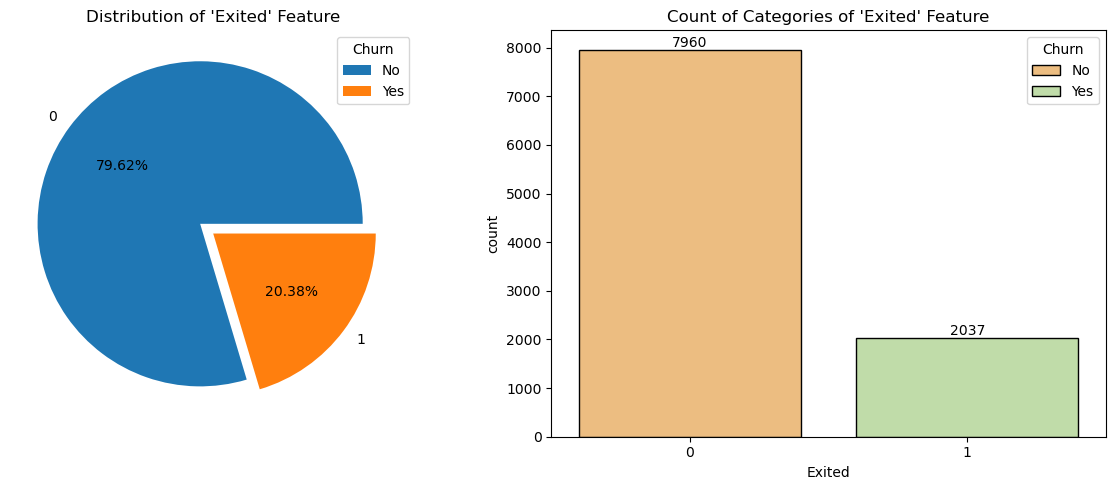

In [45]:
values = df['Exited'].value_counts().values
labels = df['Exited'].value_counts().index

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.pie(x=values, labels=labels, autopct='%0.2f%%', explode=[0.1, 0])
plt.legend(title = 'Churn', labels=['No', 'Yes'])
plt.title("Distribution of 'Exited' Feature")

plt.subplot(1, 2, 2)
ax = sns.countplot(data=df, x='Exited', edgecolor = 'black', palette = 'Spectral')
for bars in ax.containers:
    ax.bar_label(bars)
plt.legend(title = 'Churn', labels=['No', 'Yes'])
plt.title("Count of Categories of 'Exited' Feature")

plt.tight_layout()
plt.show()

**6.1. Observations**
- It is seen that majority of the customers are retained (79.6%) whereas around 20% of the customers have churned, suggesting that there is imbalance in the target feature.
- Decision regarding bringing the balance in the distribution to be taken at later stage of the modeling.

## 6.2. Analysis of Categorical Features

### Univariate Analysis

In [46]:
categorical_col = ['Gender', 'Geography', 'HasCrCard', 'IsActiveMember']

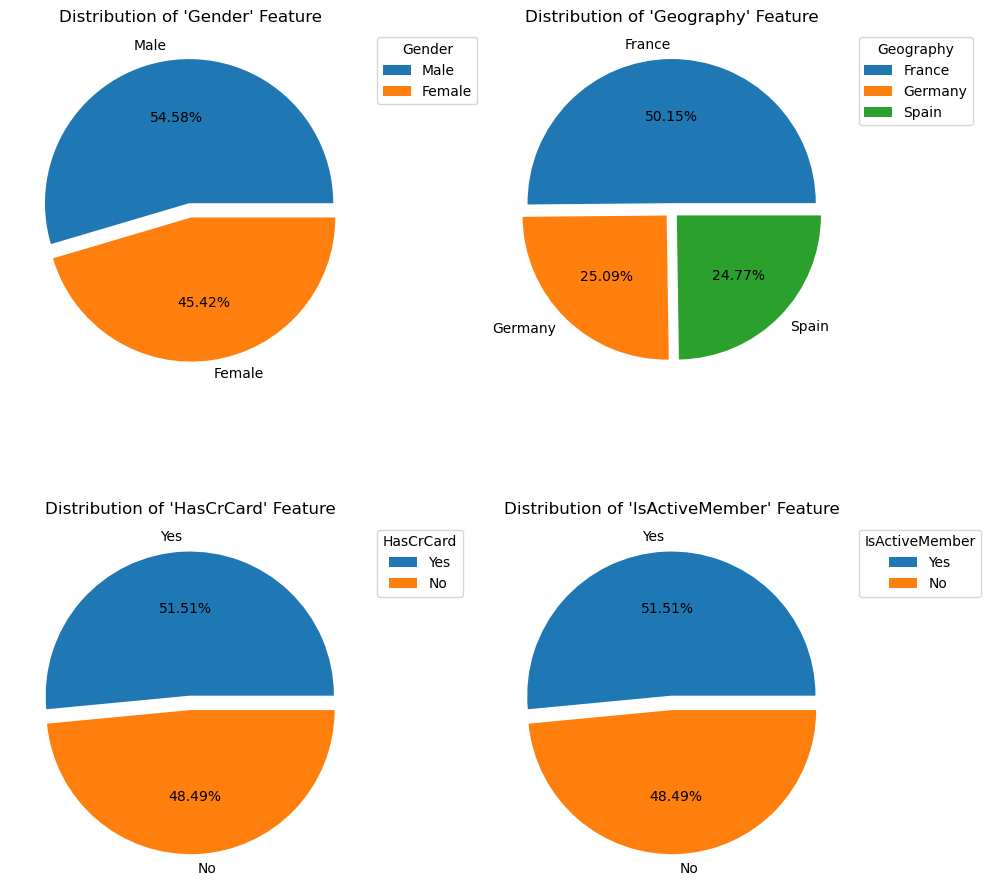

In [47]:
pie_plot(data = df, 
         features = categorical_col, 
         size_x = 10,
         size_y = 10)

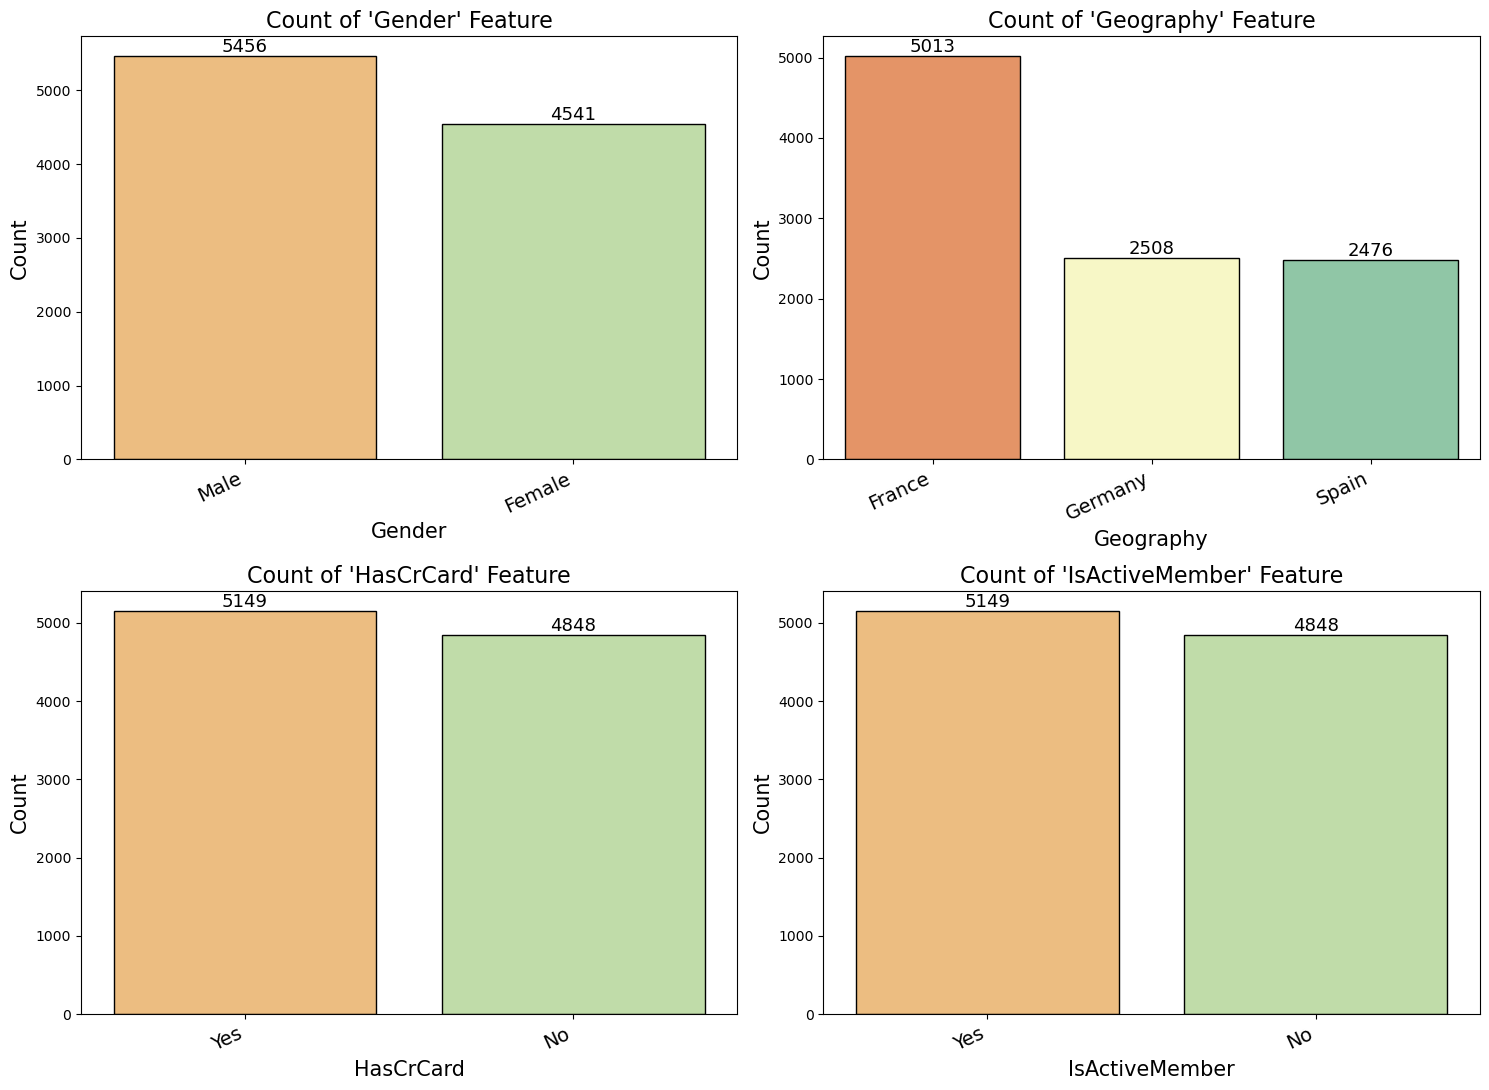

In [48]:
count_plot(data = df,
           features = categorical_col,
           size_x = 15,
           size_y = 11)

### Bivariate Analysis

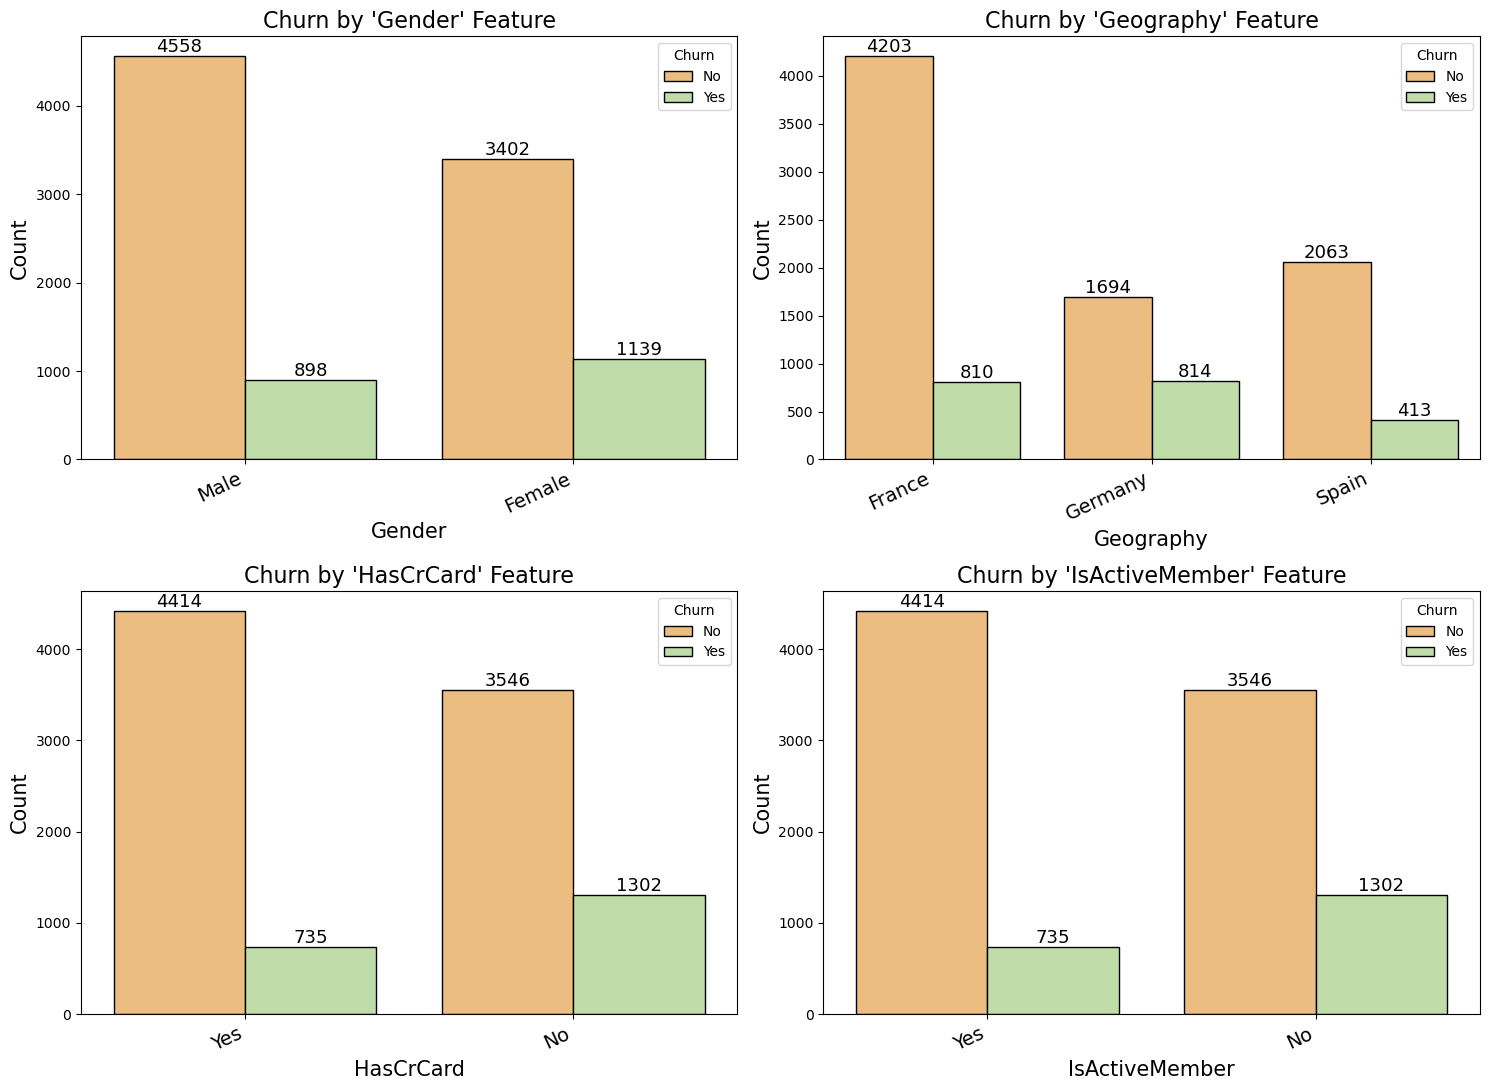

In [49]:
count_plot(data = df,
           features = categorical_col, 
           target_col = 'Exited',
           size_x = 15,
           size_y = 11)

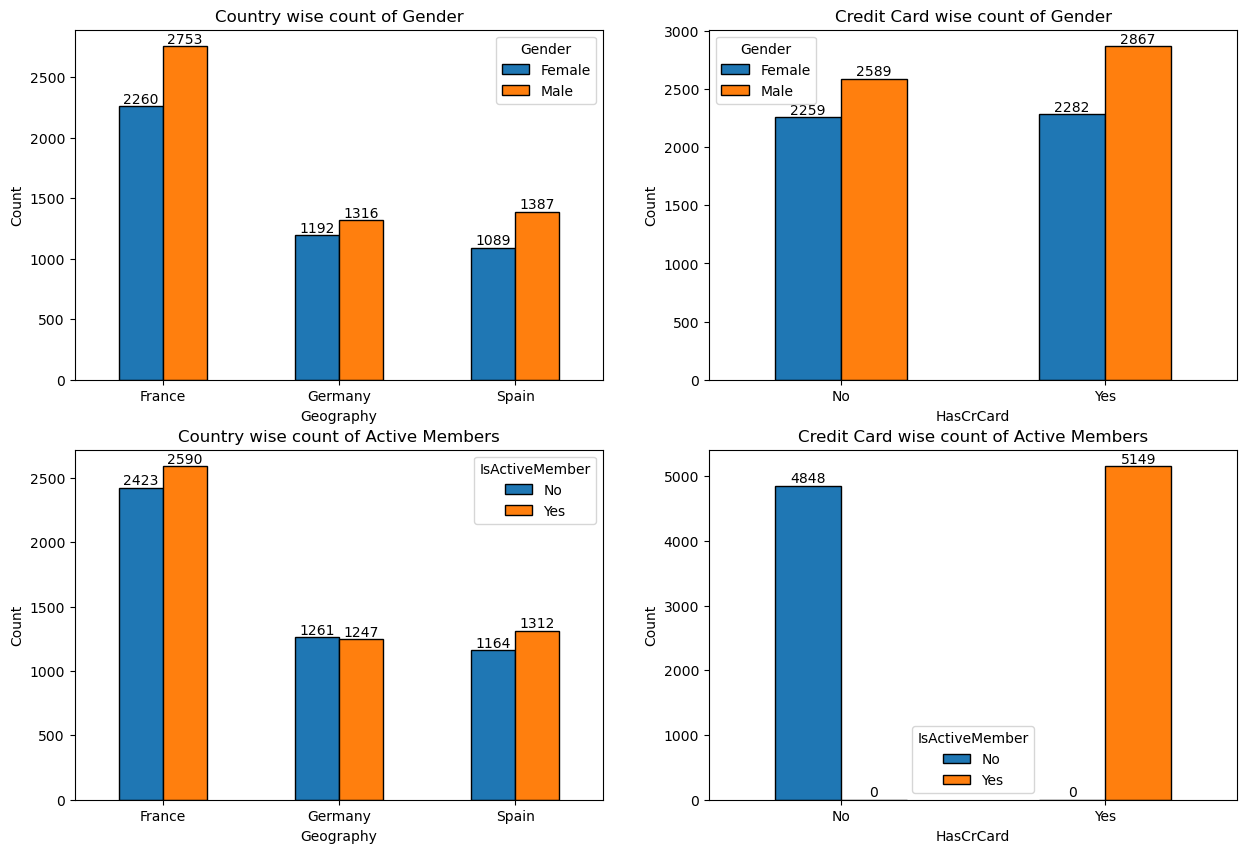

In [50]:
fig, (ax1, ax2) = plt.subplots(2,2, figsize = (15,10))

df1 = pd.crosstab(index = df['Geography'], columns = df['Gender'])
df2 = pd.crosstab(index = df['HasCrCard'], columns = df['Gender'])
df3 = pd.crosstab(index = df['Geography'], columns = df['IsActiveMember'])
df4 = pd.crosstab(index = df['HasCrCard'], columns = df['IsActiveMember'])

ax = df1.plot(kind = 'bar', ax = ax1[0], ylabel = 'Count', rot = 0,
              edgecolor = 'black', title = 'Country wise count of Gender')
for bars in ax.containers:
    ax.bar_label(bars)

ax = df2.plot(kind = 'bar', ax = ax1[1], ylabel = 'Count', rot = 0,
              edgecolor = 'black', title = 'Credit Card wise count of Gender')
for bars in ax.containers:
    ax.bar_label(bars)

ax = df3.plot(kind = 'bar', ax = ax2[0], ylabel = 'Count', rot = 0,
              edgecolor = 'black', title = 'Country wise count of Active Members')
for bars in ax.containers:
    ax.bar_label(bars)

ax = df4.plot(kind = 'bar', ax = ax2[1], ylabel = 'Count', rot = 0,
              edgecolor = 'black', title = 'Credit Card wise count of Active Members')
for bars in ax.containers:
    ax.bar_label(bars)

In [51]:
df.duplicated(subset = ['HasCrCard', 'IsActiveMember'], keep = False).sum()

9997

In [52]:
(df['HasCrCard'] == df['IsActiveMember']).all()

True

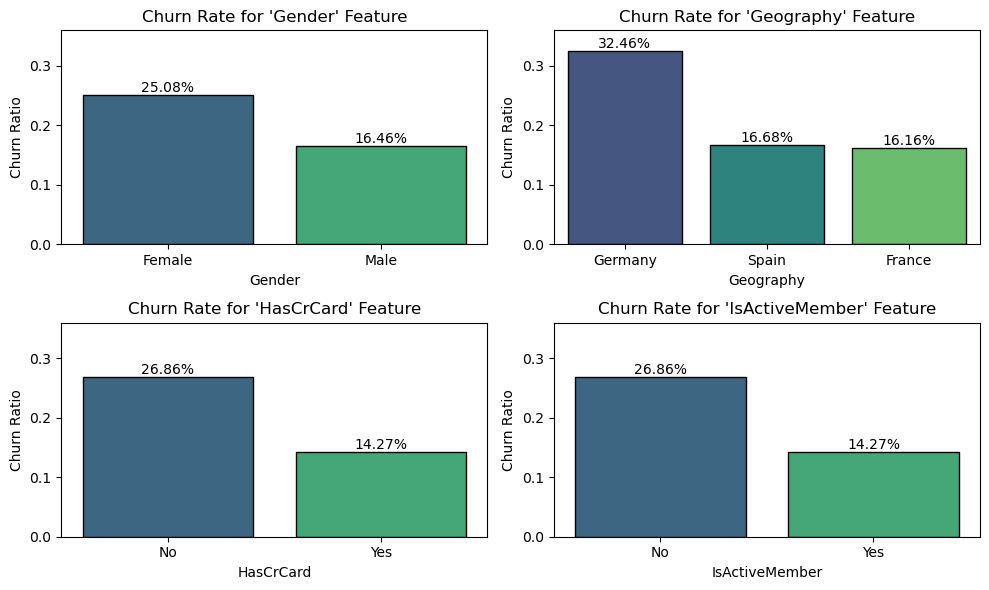

In [53]:
churn_rate(data = df,
           features = categorical_col, 
           target_col = 'Exited',
           y_lim_max = 0.36)

### Multivariate Analysis

In [54]:
pd.crosstab(index = df['HasCrCard'],
            columns = df['Gender'],
            values = df['Exited']*100,
            aggfunc = 'mean')

Gender,Female,Male
HasCrCard,,
No,32.093847,22.286597
Yes,18.141981,11.196373


In [55]:
pd.crosstab(index = df['IsActiveMember'],
            columns = df['Gender'],
            values = df['Exited']*100,
            aggfunc = 'mean')

Gender,Female,Male
IsActiveMember,,
No,32.093847,22.286597
Yes,18.141981,11.196373


In [56]:
pd.crosstab(index = df['Geography'],
            columns = df['IsActiveMember'],
            values = df['Exited']*100,
            aggfunc = 'mean')

IsActiveMember,No,Yes
Geography,,
France,21.130830,11.505792
Germany,41.078509,23.736969
Spain,23.367698,10.746951


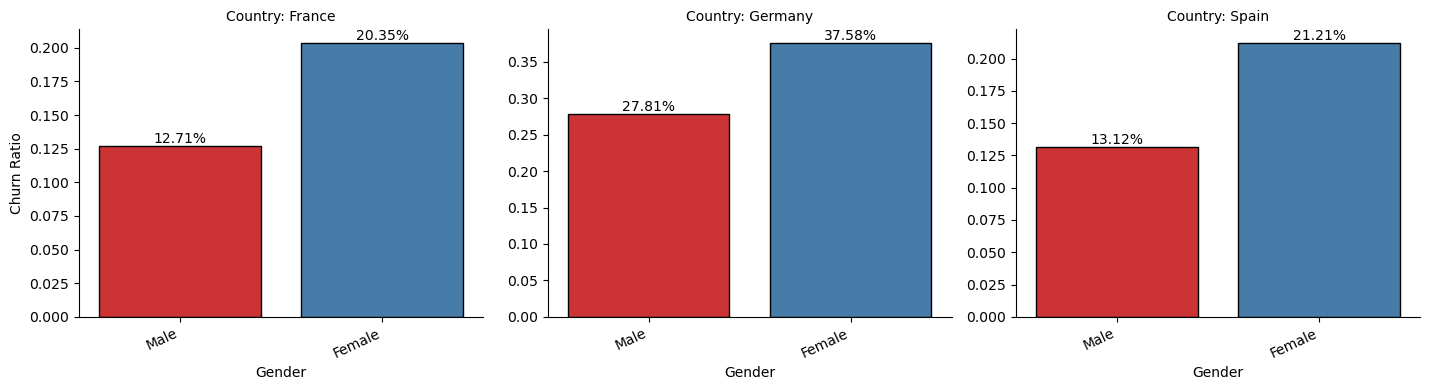

In [57]:
multivariate_plot(data = df,
                  col = 'Geography',
                  x = 'Gender',
                  y = 'Exited',
                  order = df['Gender'].value_counts().index,
                  title_template = 'Country: {col_name}')

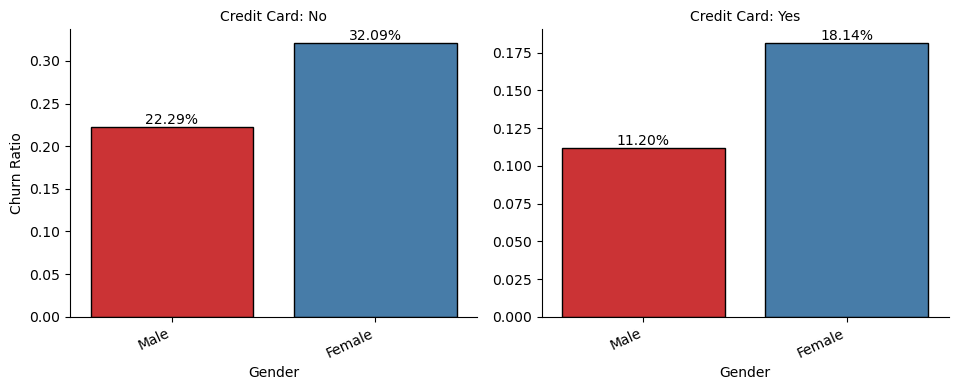

In [58]:
multivariate_plot(data = df,
                  col = 'HasCrCard',
                  x = 'Gender',
                  y = 'Exited',
                  order = df['Gender'].value_counts().index,
                  title_template = 'Credit Card: {col_name}')

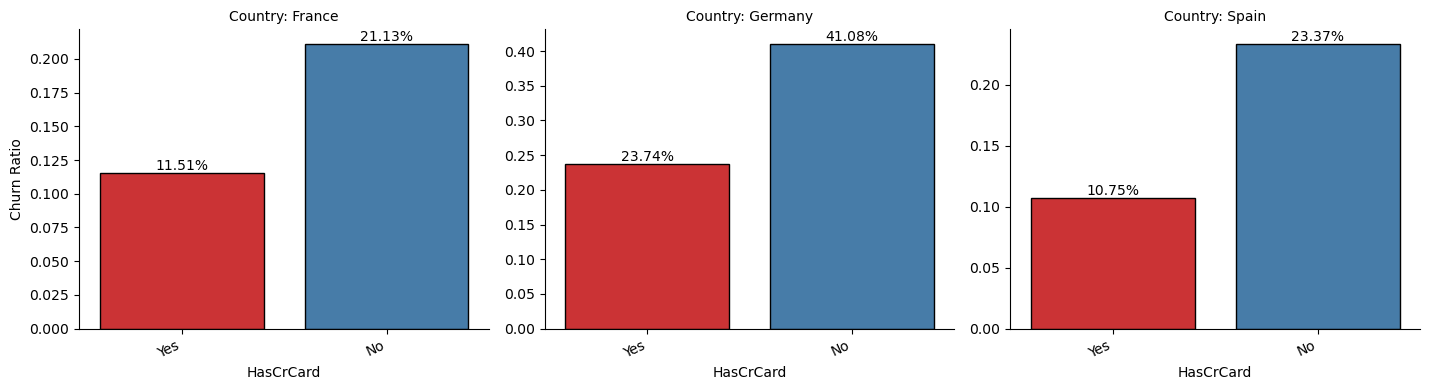

In [59]:
multivariate_plot(data = df,
                  col = 'Geography',
                  x = 'HasCrCard',
                  y = 'Exited',
                  order = df['HasCrCard'].value_counts().index,
                  title_template = 'Country: {col_name}')

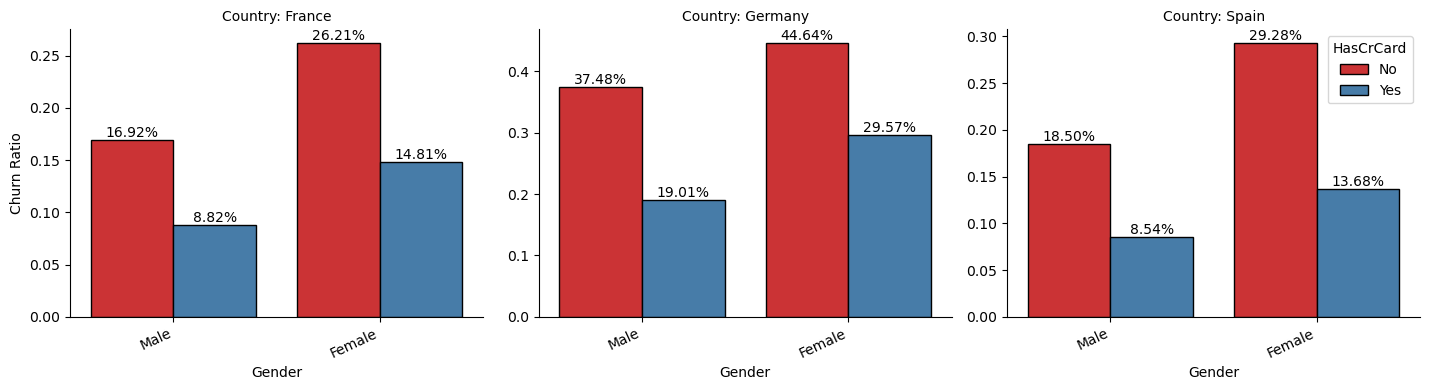

In [60]:
multivariate_plot(data = df,
                  col = 'Geography',
                  x = 'Gender',
                  y = 'Exited', 
                  hue = 'HasCrCard', 
                  order = df['Gender'].value_counts().index,
                  title_template = 'Country: {col_name}')

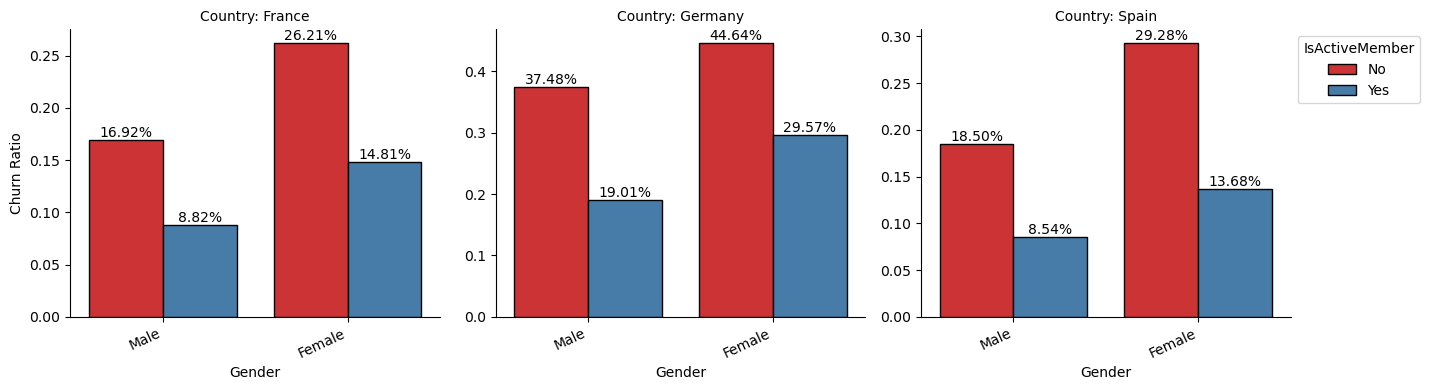

In [61]:
multivariate_plot(data = df,
                  col = 'Geography',
                  x = 'Gender',
                  y = 'Exited',
                  hue = 'IsActiveMember', 
                  order = df['Gender'].value_counts().index,
                  title_template = 'Country: {col_name}')

**6.2. Observations**

**Distribution**
- The number of male customers is more than the female customers (54.6% vs 45.4%).
- Half of the customers reside at France with the remaining half almost equally distributed in the countries Germany and Spain.
- Interestingly, all customers who are inactive do not own a credit card and all those who are active do own a credit card.
- Of the total, 51.5% customers are active members (or own a credit card) as opposed to 48.5% inactive customers (or do not have a credit card).
- Country-wise distribution of gender as well as distribution of gender with respect to active members show similar pattern where female customers are less in number when compared to male customers.
- Except for Germany, where inactive customers are slightly higher, the number of active customers is greater in France and Spain.

**With respect to Churn**
- Churn rate for female customers is higher (25.08%) as compared to male customers (16.46%). Trend is the same for all 3 countries with female customers more likely to leave the Bank, where maximum churn rate for female customers comes from Germany (37.58%).
- Female customers who do not own credit cards or those female customers who are not active have exited Bank with a churn rate of 32.09%.
- Though the number of customers from Germany is less, it has the highest churning rate of 32.46%.
- It is to note that, customers with no credit cards or those who are inactive members are more likely to exit Bank as their churn rate is 26.86% as opposed to a retention rate of 14.27%.
- Germany based inactive members (or those without credit cards) exhibit 41.08% churn.
- Whereas likelihood of churning goes even higher if the customers are Germany residents, female and are inactive or not owning credit card (44.64% rate of churning).

## 6.3. Analysis of Discrete Numerical Features

In [62]:
discrete_col

['Tenure', 'NumOfProducts']

In [63]:
tenure_bins = [-1,2,4,7,11]
tenure_labels = ['New', 'Emerging', 'Established', 'Long-Term']

product_bins = [0,1,4]
product_labels = ['1', '2 or More']

df = (
    df
    .assign(
        Tenure_Category = lambda df_: pd.cut(df_['Tenure'], bins = tenure_bins, 
                                             labels = tenure_labels, right = True),
        Products_Category = lambda df_: pd.cut(df_['NumOfProducts'], bins = product_bins, 
                                               labels = product_labels, right = True)
    )
)
display(df[['Tenure', 'Tenure_Category', 'NumOfProducts', 'Products_Category', 'Exited']].sample(5))

,Tenure,Tenure_Category,NumOfProducts,Products_Category,Exited
9892,1,New,2,2 or More,0
7139,8,Long-Term,1,1,0
7626,5,Established,2,2 or More,0
5279,6,Established,2,2 or More,0
5743,6,Established,2,2 or More,0


In [64]:
display(
    df
    .assign(**df[discrete_col].astype('category')
    )
    [['Tenure', 'Tenure_Category', 'NumOfProducts', 'Products_Category']]
    .describe(include = 'category')
)

,Tenure,Tenure_Category,NumOfProducts,Products_Category
count,9997,9997,9997,9997
unique,11,4,4,2
top,2,Established,1,1
freq,1047,3006,5081,5081


In [65]:
display(
    df
    .assign(**df[discrete_col].astype('category'))
    .groupby(by = 'Exited')
    [['Tenure', 'Tenure_Category', 'NumOfProducts', 'Products_Category']].describe()
)

Tenure                 Tenure_Category                            \
        count unique top freq           count unique          top  freq   
Exited                                                                    
0        7960     11   7  851            7960      4  Established  2424   
1        2037     11   1  232            2037      4  Established   582   

       NumOfProducts                  Products_Category                    \
               count unique top  freq             count unique        top   
Exited                                                                      
0               7960      3   2  4242              7960      2  2 or More   
1               2037      4   1  1409              2037      2          1   

              
        freq  
Exited        
0       4288  
1       1409

### Univariate Analysis

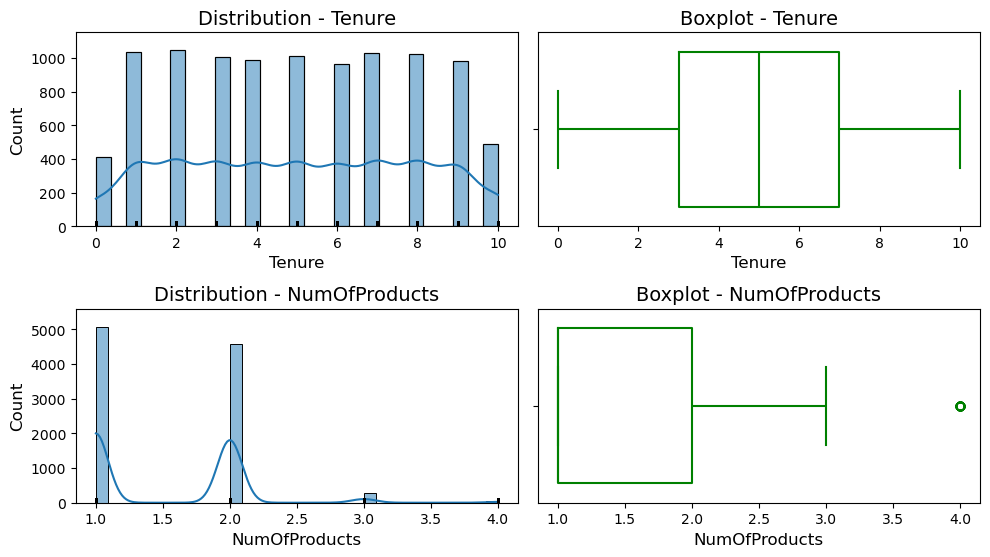

In [66]:
distribution_plot(data = df,
                  features = discrete_col)

### Bivariate Analysis

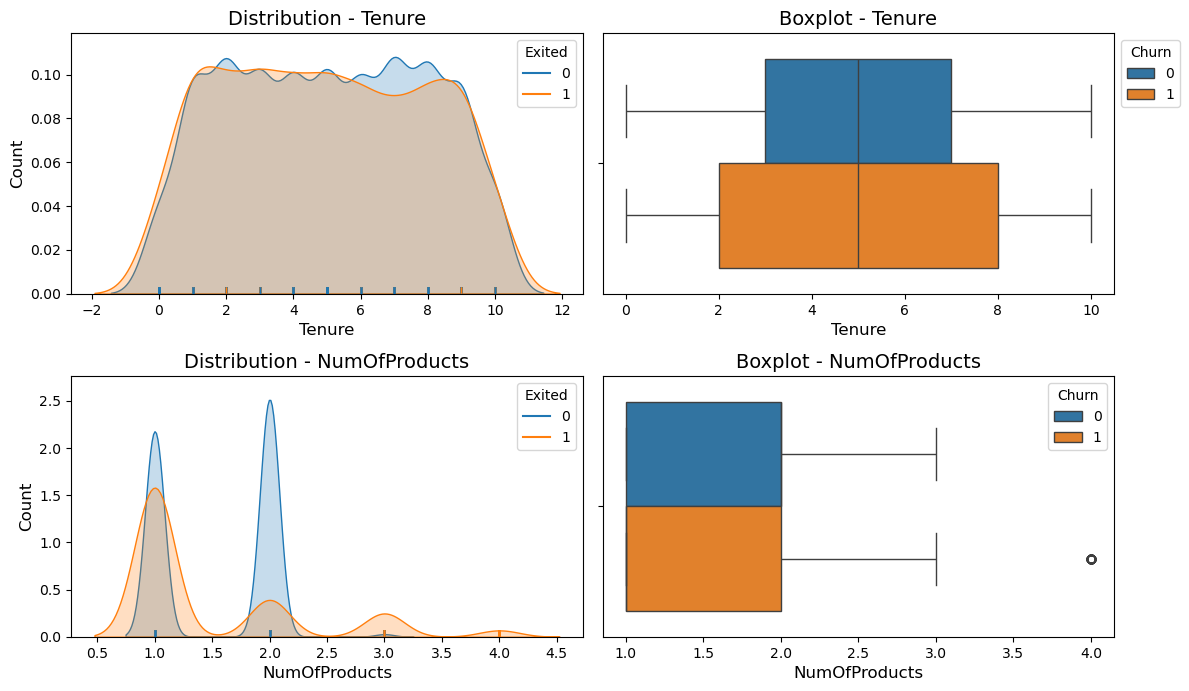

In [67]:
distribution_plot(data = df,
                  features = discrete_col,
                  hue = 'Exited',
                  size_x = 12,
                  size_y = 10)

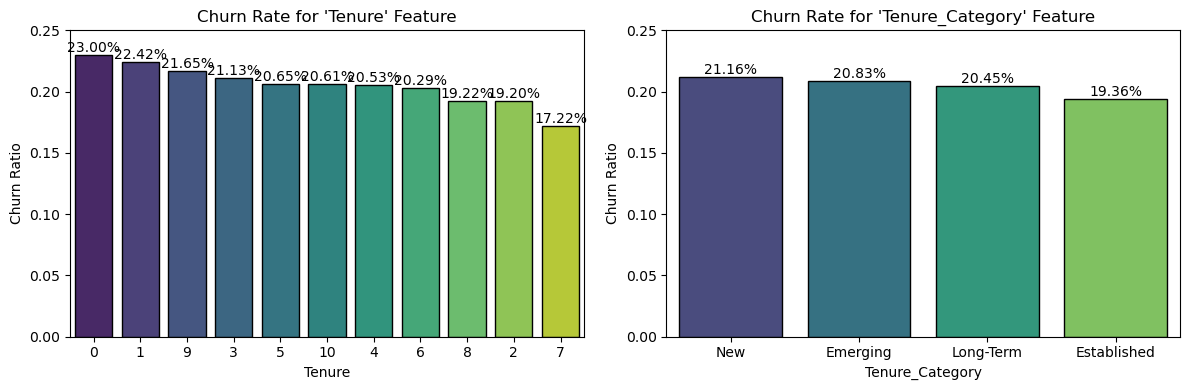

In [68]:
churn_rate(data = df,
           features = ['Tenure', 'Tenure_Category'], 
           target_col = 'Exited',
           y_lim_max = 0.25,
           size_x = 12,
           size_y = 4)

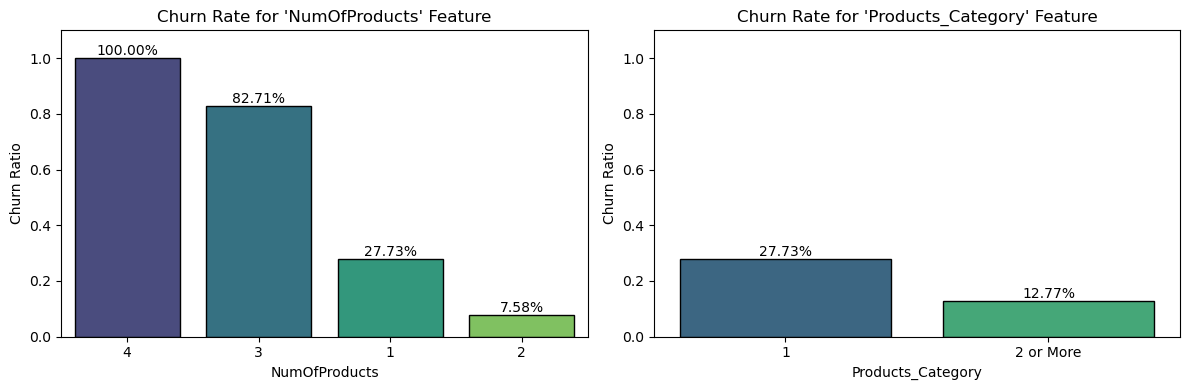

In [69]:
churn_rate(data = df,
           features = ['NumOfProducts', 'Products_Category'], 
           target_col = 'Exited',
           y_lim_max = 1.1,
           size_x = 12,
           size_y = 4)

**6.3. Observations**

**a. 'Tenure'**
- Customers tenure with the Bank is uniformly distributed.
- Customers that exited the Bank have tenure ranging from 0 to 10 years with 50% tenure range from 2 to 8 years. While those retained have 50% tenure range from 3 to 7 years. This overlap suggests that 'Tenure' may not be strictly tenure-dependent as there is mixed behavior of customers within the tenure band and there might be different possible reasons for churn.
- Treating this feature as categorical shows that customers with tenure of 1 year are more likely to churn and those with 7 years of tenure are retained.
- Binning was performed to study the effect of this feature on churn.
- The results suggest that 'New' customers (0-1 years of tenure) churn the most at 21.16% followed by 'Emerging' (2-4 years), while 'Established' (4-7 years of tenure) category is good at retention of customers.

**b. 'NumOfProducts'**
- Majority of the customers use 1 or 2 products, while only about 3% of the customers combinely use 3 or 4 products. This is evidently imbalanced distribution.
- All of the 60 customers who have access to 4 products have churned (100% rate). Also churn rate is around 83% for 3 products. But since these are very rare categories, it could misinterprete trends for a larger population and affect the prediction. To avoid the risk of overfitting, we bin this feature into 2 categories - '1' and '2 or more' products to get balanced distribution of categories.
- After binning, it is safe to infer that customers with just 1 product are likely to leave bank at 27.73% rate as opposed to customers with 2 or more products.

## 6.4. Analysis of Numerical Features

### 6.4.1. Overall Statistics Summary

In [70]:
(
    df[numerical_col]
    .describe()
    .T
)

,count,mean,std,min,25%,50%,75%,max
CreditScore,9997.0,650.545364,96.657932,350.00,584.00,652.00,718.00,850.00
Age,9997.0,38.922077,10.489072,18.00,32.00,37.00,44.00,92.00
EstimatedSalary,9997.0,100092.222656,57518.775702,11.58,50974.57,100236.02,149399.70,199992.48
Balance,9997.0,76482.679807,62397.174721,0.00,0.00,97188.62,127642.44,250898.09


### 6.4.2. Percentiles

In [71]:
display(
    quantile_multiple_features(df, numerical_col)
)

Percentile Summary:


,CreditScore,Age,EstimatedSalary,Balance
Percentile,,,,
0,350.0,18.0,11.580,0.000
10,521.0,27.0,20263.710,0.000
20,566.0,31.0,41044.484,0.000
30,599.0,33.0,60727.392,0.000
40,627.0,35.0,80236.940,73077.332
50,652.0,37.0,100236.020,97188.620
60,678.0,40.0,119733.360,110128.966
70,704.0,42.0,139438.492,122029.630
80,735.0,46.0,159839.564,133706.820


### 6.4.3. Measure of Central Tendency

In [72]:
stats_summary(data = df,
              features = numerical_col,
              central_tendency = True)

Measure of Central Tendency:


,Mean,Trimmed Mean (10%),Trimmed Mean (20%),Median
CreditScore,650.545364,651.031129,651.381064,652.00
Age,38.922077,37.915239,37.544257,37.00
EstimatedSalary,100092.222656,100117.311809,100048.519038,100236.02
Balance,76482.679807,74823.117435,76245.241797,97188.62


### 6.4.4. Measure of Spread

In [73]:
stats_summary(data = df,
              features = numerical_col,
              measure_of_spread = True)

Measure of Spread:


,Variance,Standard Deviation,Median Absolute Deviation (MAD),Inter-Quartile Range (IQR)
CreditScore,9.342756e+03,96.657932,67.00,134.00
Age,1.100206e+02,10.489072,6.00,12.00
EstimatedSalary,3.308410e+09,57518.775702,49182.39,98425.13
Balance,3.893407e+09,62397.174721,46777.68,127642.44


### 6.4.5. Measure of Symmetricity

In [74]:
stats_summary(data = df,
              features = numerical_col,
              skewness_kurtosis = True)

Skewness and Kurtosis:


,Skewness,Kurtosis
CreditScore,-0.071926,-0.425621
Age,1.011201,1.394417
EstimatedSalary,0.001986,-1.182022
Balance,-0.140961,-1.489332


### 6.4.6. Visualizations

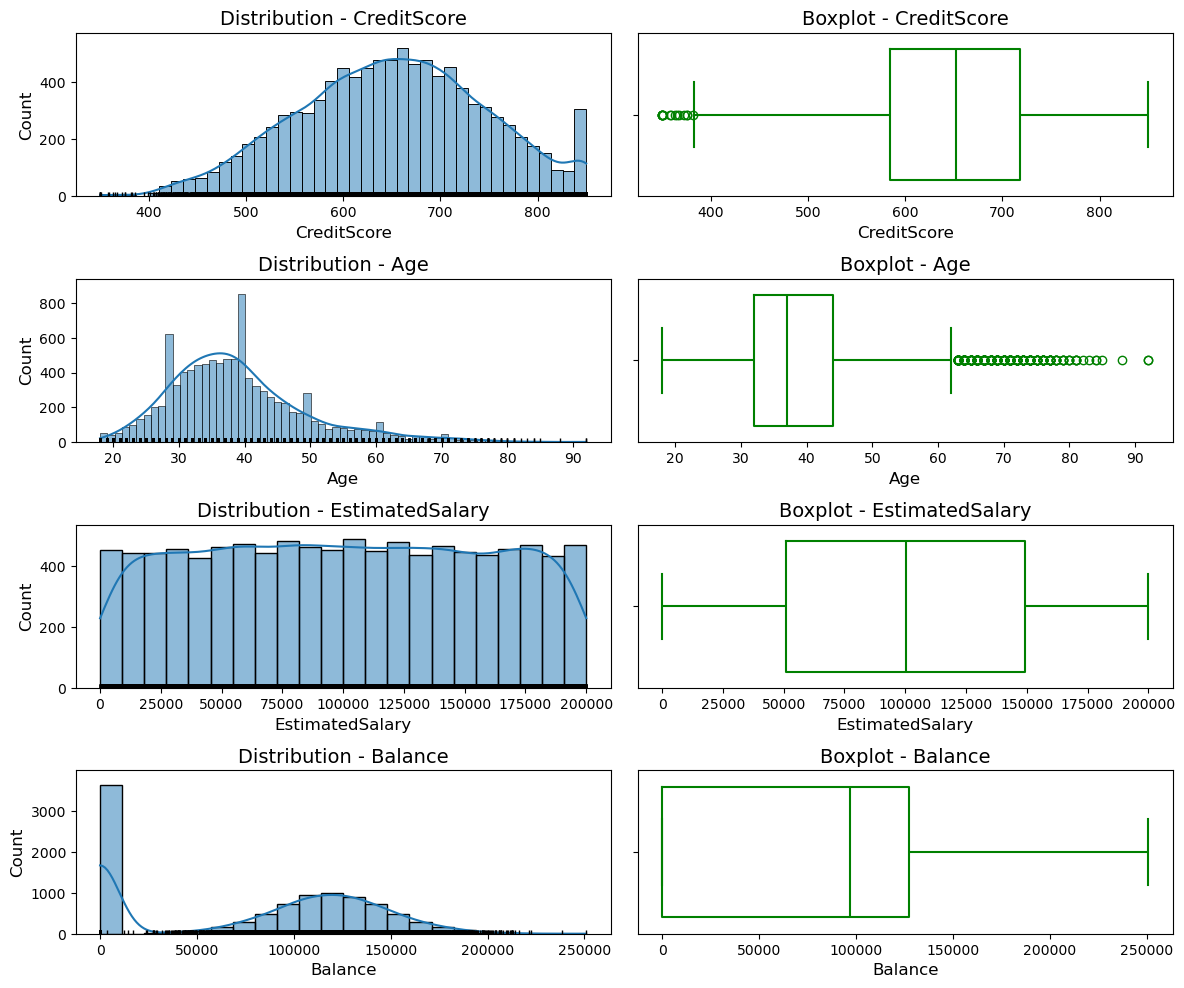

In [75]:
distribution_plot(data = df,
                  features = numerical_col,
                  size_x = 12,
                  size_y = 12)

In [76]:
df[df['CreditScore'] < 400].shape[0]

19

In [77]:
display(df.groupby(by = 'Exited')['CreditScore'].describe())

,count,mean,std,min,25%,50%,75%,max
Exited,,,,,,,,
0,7960.0,651.874497,95.659046,405.0,585.0,653.0,718.0,850.0
1,2037.0,645.351497,100.321503,350.0,578.0,646.0,716.0,850.0


In [78]:
display(df.groupby(by = 'Exited')['Age'].describe())

,count,mean,std,min,25%,50%,75%,max
Exited,,,,,,,,
0,7960.0,37.408166,10.126880,18.0,31.0,36.0,41.0,92.0
1,2037.0,44.837997,9.761562,18.0,38.0,45.0,51.0,84.0


In [79]:
display(df.groupby(by = 'Exited')['EstimatedSalary'].describe())

,count,mean,std,min,25%,50%,75%,max
Exited,,,,,,,,
0,7960.0,99740.749342,57415.983838,90.07,50781.7675,99620.355,148630.9225,199992.48
1,2037.0,101465.677531,57912.418071,11.58,51907.7200,102460.840,152422.9100,199808.10


In [80]:
display(df.groupby(by = 'Exited')['Balance'].describe())

,count,mean,std,min,25%,50%,75%,max
Exited,,,,,,,,
0,7960.0,72739.856206,62847.640529,0.0,0.00,92063.06,126401.23,221532.80
1,2037.0,91108.539337,58360.794816,0.0,38340.02,109349.29,131433.33,250898.09


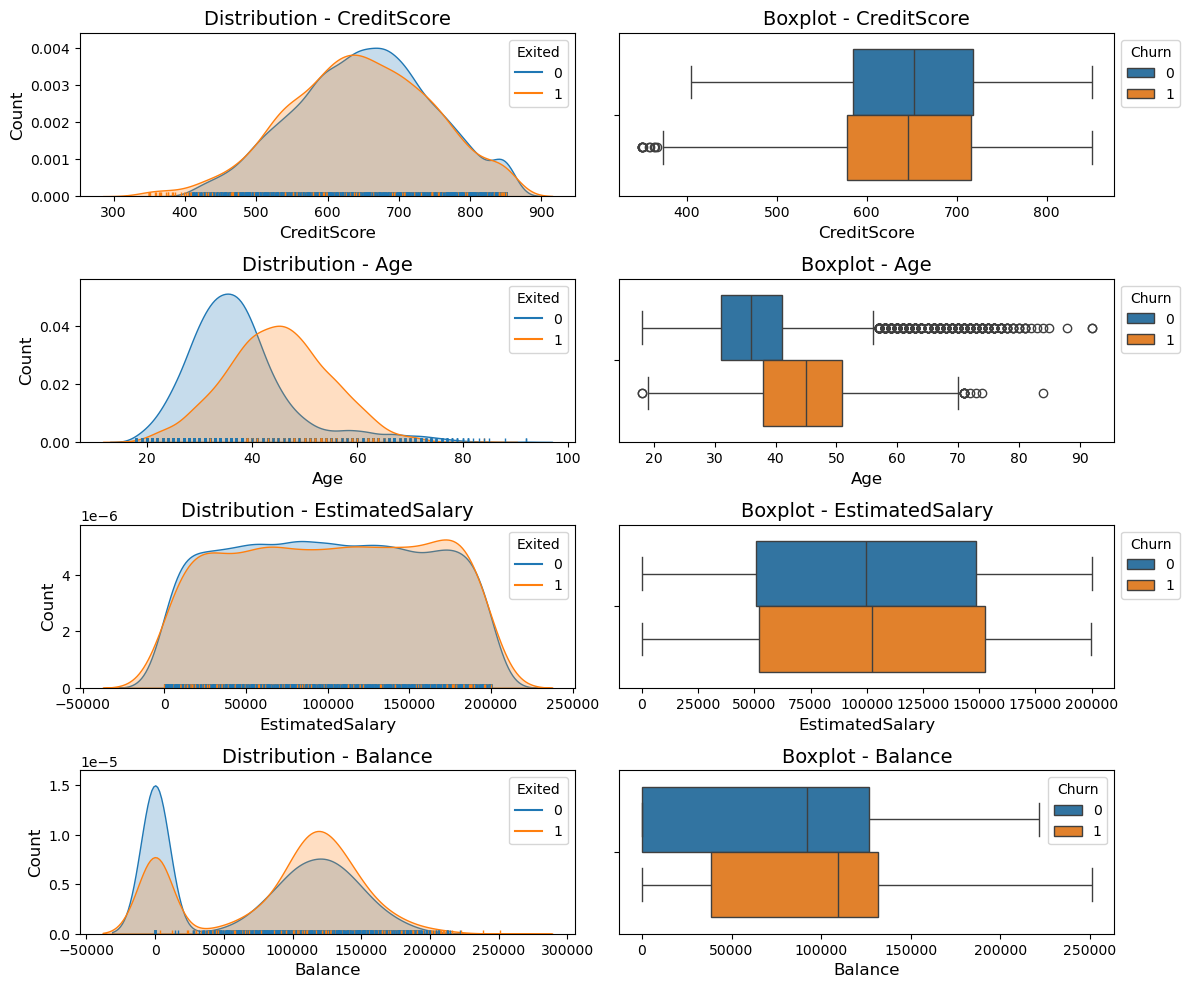

In [81]:
distribution_plot(data = df,
                  features = numerical_col,
                  hue = 'Exited',
                  size_x = 12,
                  size_y = 12)

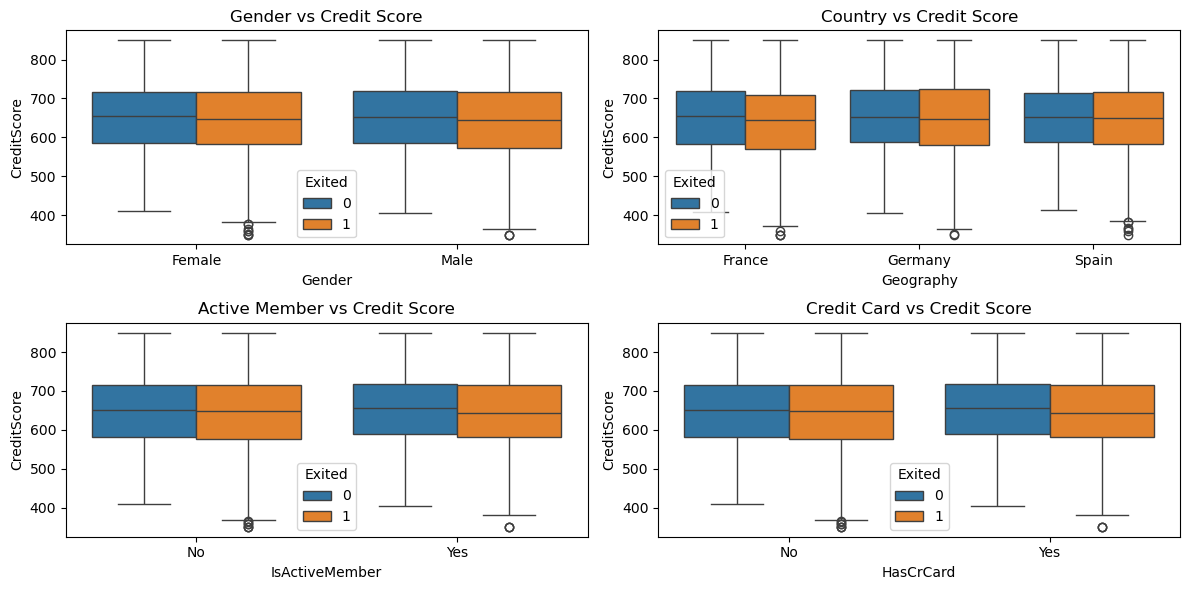

In [82]:
fig, (ax1, ax2) = plt.subplots(2,2, figsize = (12,6))
sns.boxplot(data = df, x = 'Gender', y = 'CreditScore', hue = 'Exited', ax = ax1[0])
ax1[0].set_title('Gender vs Credit Score')
sns.boxplot(data = df, x = 'Geography', y = 'CreditScore', hue = 'Exited', ax = ax1[1])
ax1[1].set_title('Country vs Credit Score')
sns.boxplot(data = df, x = 'IsActiveMember', y = 'CreditScore', hue = 'Exited', ax = ax2[0])
ax2[0].set_title('Active Member vs Credit Score')
sns.boxplot(data = df, x = 'HasCrCard', y = 'CreditScore', hue = 'Exited', ax = ax2[1])
ax2[1].set_title('Credit Card vs Credit Score')
plt.tight_layout()
plt.show()

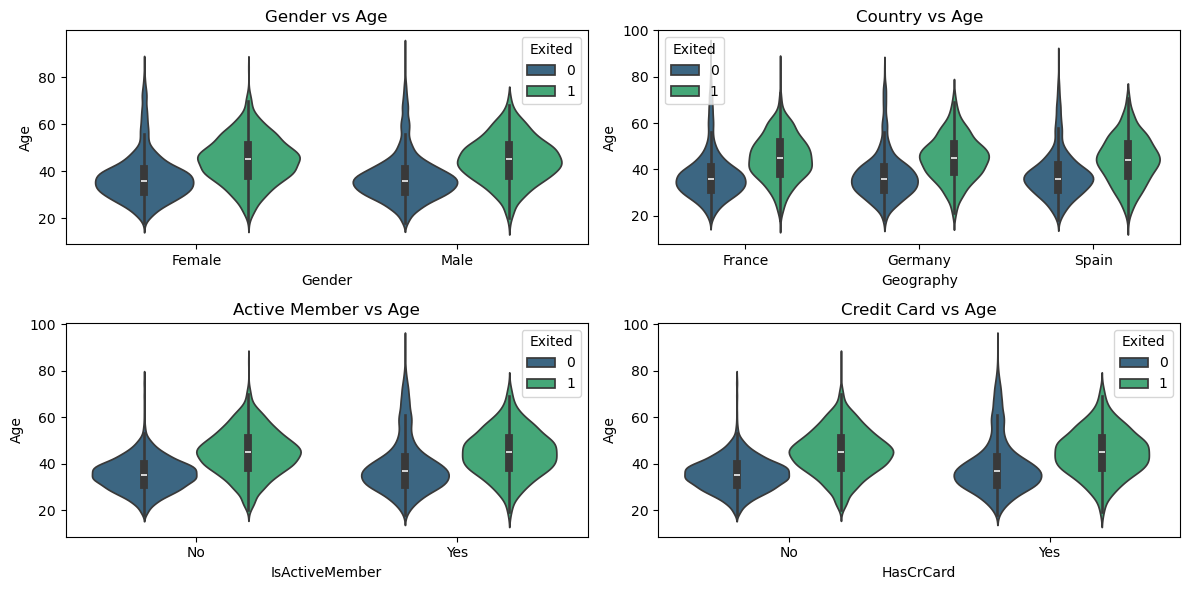

In [83]:
fig, (ax1, ax2) = plt.subplots(2,2, figsize = (12,6))
sns.violinplot(data = df, x = 'Gender', y = 'Age', hue = 'Exited', ax = ax1[0], palette = 'viridis')
ax1[0].set_title('Gender vs Age')
sns.violinplot(data = df, x = 'Geography', y = 'Age', hue = 'Exited', ax = ax1[1], palette = 'viridis')
ax1[1].set_title('Country vs Age')
sns.violinplot(data = df, x = 'IsActiveMember', y = 'Age', hue = 'Exited', ax = ax2[0], palette = 'viridis')
ax2[0].set_title('Active Member vs Age')
sns.violinplot(data = df, x = 'HasCrCard', y = 'Age', hue = 'Exited', ax = ax2[1], palette = 'viridis')
ax2[1].set_title('Credit Card vs Age')
plt.tight_layout()
plt.show()

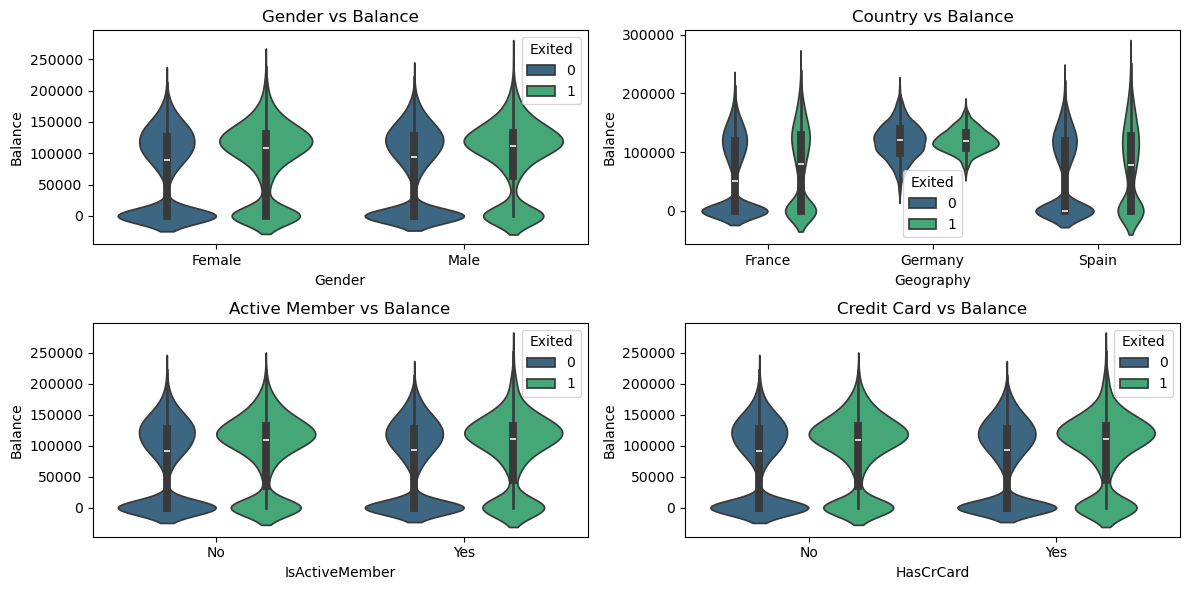

In [84]:
fig, (ax1, ax2) = plt.subplots(2,2, figsize = (12,6))
sns.violinplot(data = df, x = 'Gender', y = 'Balance', hue = 'Exited', ax = ax1[0], palette = 'viridis')
ax1[0].set_title('Gender vs Balance')
sns.violinplot(data = df, x = 'Geography', y = 'Balance', hue = 'Exited', ax = ax1[1], palette = 'viridis')
ax1[1].set_title('Country vs Balance')
sns.violinplot(data = df, x = 'IsActiveMember', y = 'Balance', hue = 'Exited', ax = ax2[0], palette = 'viridis')
ax2[0].set_title('Active Member vs Balance')
sns.violinplot(data = df, x = 'HasCrCard', y = 'Balance', hue = 'Exited', ax = ax2[1], palette = 'viridis')
ax2[1].set_title('Credit Card vs Balance')
plt.tight_layout()
plt.show()

In [85]:
display(
    df
    .groupby(by = ['Exited', 'Geography', 'Gender'])
    .agg(
        Balance = ('Balance', 'median'),
        EstimatedSalary = ('EstimatedSalary', 'median'),
        Age = ('Age', 'median'),
        CreditScore = ('CreditScore', 'median'),
    )
)

Balance  EstimatedSalary   Age  CreditScore
Exited Geography Gender                                                
0      France    Female       0.000        98243.920  35.0        654.0
                 Male     62092.900        97825.230  36.0        655.0
       Germany   Female  119745.430       105323.470  36.0        652.5
                 Male    120594.060       102182.465  36.0        653.0
       Spain     Female       0.000       101401.590  36.0        653.5
                 Male     65521.200        95562.810  36.0        650.0
1      France    Female   71423.565       101194.205  45.0        644.0
                 Male     88486.835       103917.590  45.0        642.5
       Germany   Female  118285.380       103177.515  45.0        650.0
                 Male    119972.775        92401.215  45.0        638.0
       Spain     Female   75990.970       112649.220  44.0        650.0
                 Male     80048.440        97761.355  44.0        648.0

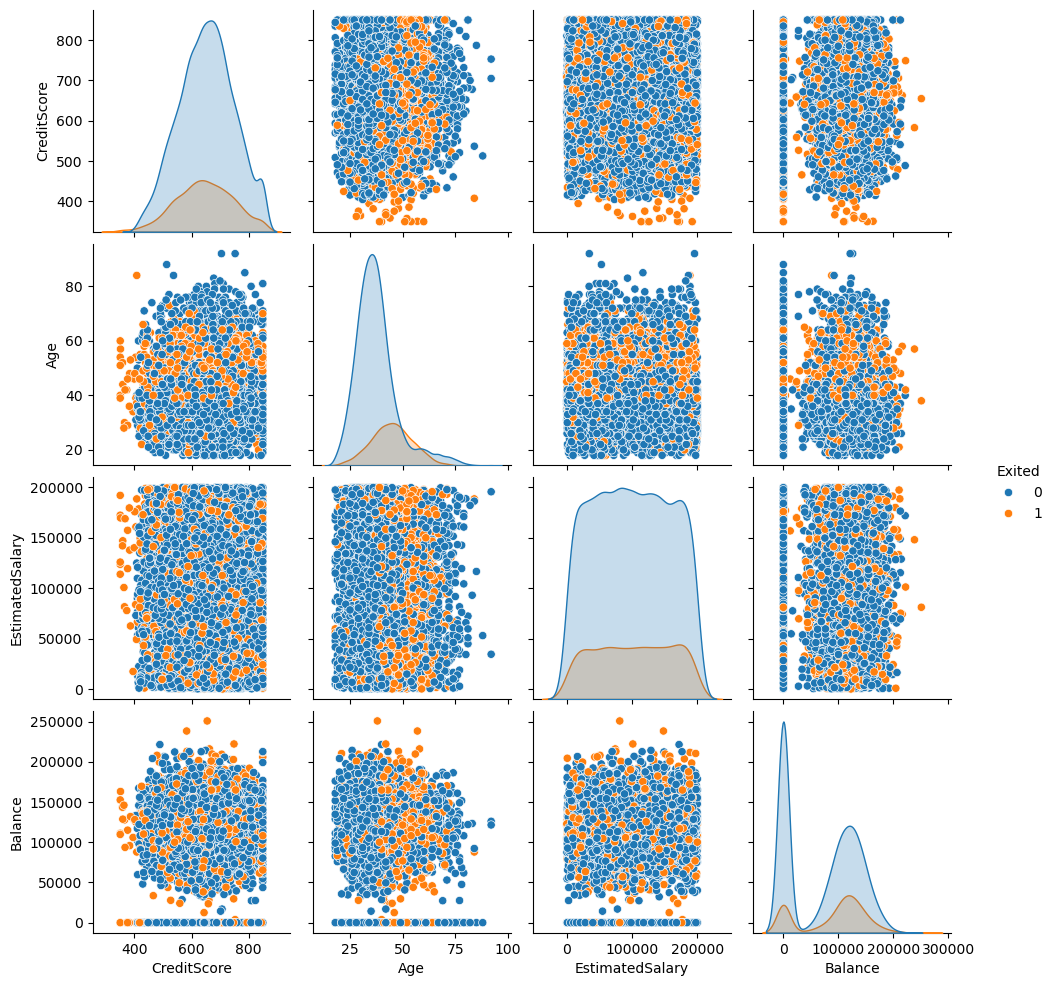

In [86]:
sns.pairplot(data = df,
             vars = ['CreditScore', 'Age', 'EstimatedSalary', 'Balance'],
             hue = 'Exited')
plt.show()

**6.4. Observations**

**Distribution**
- Credit Scores range from 350 to 850 with a mean of about 650. There are 19 customers (possibly outliers) with credit scores less than 400 suggesting that the data is slightly left skewed. With a skewness of just -0.07 we can safely assume that the distribution is fairly symmetrical.
- The Bank has customers belonging to all age groups with the youngest being 18 years and the oldest being 92 years of age.
- Half of the customers are in the age bracket of 32 to 44 years. With 90% of the customers of upto 53 years of age and only 10% of others in the bracket of 53-92 years suggests that data is right skewed (skewness: 1.01).
- Estimated Salary is uniformly distributed and the same is supported by kurtosis (<0: Platykurtic).
- 30% of the customers have zero balance.

**With respect to Churn**
- Customers with a very low credit score of upto 400 are more likely to churn. Average credit score for churned customers is a little lower than the retained customers (646 vs 653). Other than that the distribution of credit score doesn't show a clear difference between retained and churned customers.
- Interaction of credit score with other categories shows no visible trend for the classes of target variable.
- Average age of churned customers is 45 which is higher than the average age of retained customers which is around 36. It is evident that age plays an important role in deciding the churning.
- 50% of the churned ones belong to the age bracket of 38 to 51 (31 to 41 in case of retained customers), suggesting that older customers are more likely to leave the Bank.
- For all the categories of gender, country and active member; the distribution of age has the same trend suggesting that higher age groups tend to leave the Bank.
- The effect of estimated salary alone is not clear as the distribution is overlapping in nature for all the existing range.
- There are some customers who have exited with zero balance. But the trend suggests that the customers with higher balances (avg 109000) have left the Bank with maximum balance touching upto 250000.
- Customers from Germany have sufficiently higher average balances, with none of them with zero balance.
- Half of the Retained customers of Spain have zero balance and number goes high upto 79000 for churned customers.
- None of the numerical features are correlated.

# 7. Handling Outliers

In [87]:
def cap_outliers(ser):
    q1, q3 = ser.quantile([0.25, 0.75])
    iqr = q3 - q1

    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)

    ser = np.where(ser <= lower_bound, 
                   lower_bound,
                   np.where(ser >= upper_bound,
                            upper_bound,
                            ser)
                  )
    return ser

In [88]:
df = (
    df
    .assign(
        Age_Log1 = lambda df_: np.log1p(df_['Age']),
        Age_Log = lambda df_: df_['Age_Log1'].pipe(cap_outliers)
    )
    .drop(columns = ['Age', 'Age_Log1'])
)

In [89]:
df.head(2)

,CreditScore,Geography,Gender,Tenure,EstimatedSalary,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited,Tenure_Category,Products_Category,Age_Log
0,698,Spain,Female,9,90212.38,161993.89,1,No,No,0,Long-Term,1,3.688879
1,612,Spain,Male,1,83256.26,0.00,1,Yes,Yes,1,New,1,3.583519


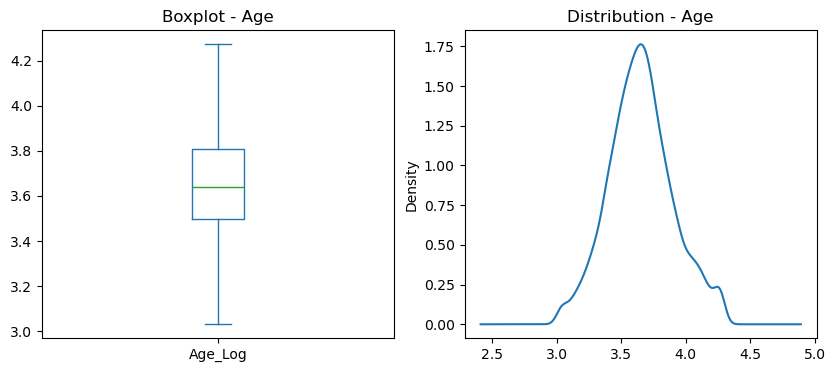

Skewness: 0.17562811754764598


In [90]:
plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.title('Boxplot - Age')
df['Age_Log'].plot(kind = 'box')
plt.subplot(1,2,2)
plt.title('Distribution - Age')
df['Age_Log'].plot(kind = 'kde')
plt.show()
print(f"Skewness: {df['Age_Log'].skew()}")

**7. Observations**
- Since the 'Age' feature is right-skewed (positively skewed), log transformation is applied to make it normally distributed.
- Outliers are then handled using IQR proximity method where the respective outliers are capped at the lower bound or upper bound.

# 8. Correlation Analysis
## 8.1. Correlation of Independent Features

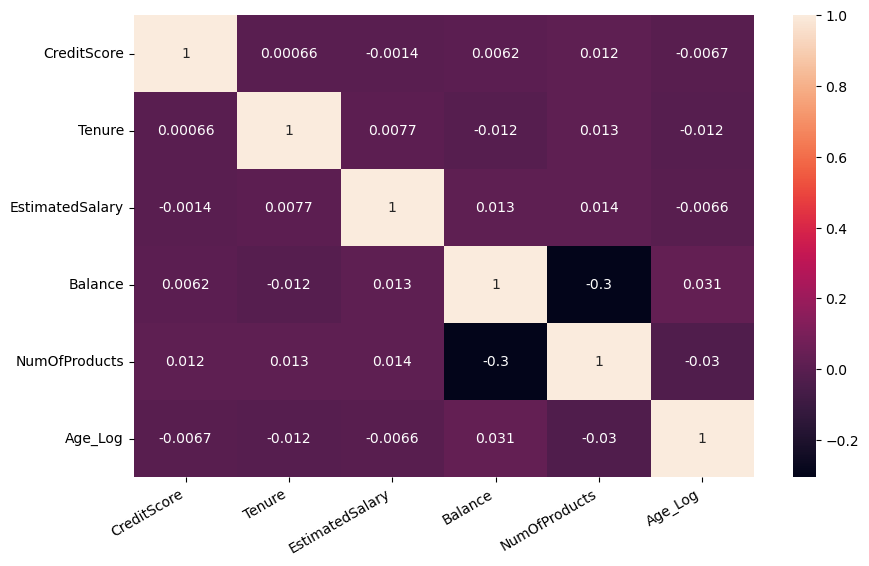

In [91]:
plt.figure(figsize = (10,6))
sns.heatmap(df.drop(columns = ['Exited']).corr(numeric_only = True), annot = True)
plt.xticks(rotation = 30, ha = 'right')
plt.show()

**8.1. Observations**
- None of the numerical features are correlated, except for 'Balance' & 'NumOfProducts' features which shows weak negative correlation (-0.3).

## 8.2. Correlation of Numeric Features with Target Feature

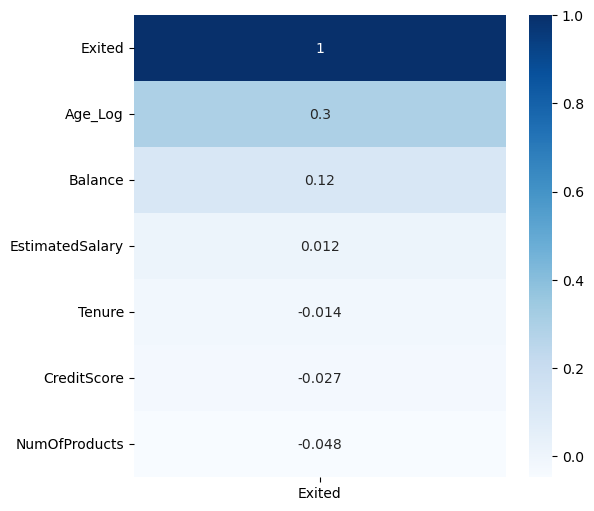

In [92]:
plt.figure(figsize = (6,6))
(
   sns.heatmap(df.corr(numeric_only = True)
               [['Exited']].sort_values('Exited', ascending = False), 
               annot = True, cmap = 'Blues')
)
plt.show()

**8.2. Observations**
- With respect to the target feature ('Exited'), 'Age' & 'Balance' features show weak postive correlation.
- Other features are almost negligible in terms of correlation with 'Exited' feature.

### Final DataFrame

In [93]:
final_categorical_col = ['Geography', 'Gender', 'HasCrCard']
final_numerical_col = ['Tenure', 'NumOfProducts', 'CreditScore', 'Age_Log', 'EstimatedSalary', 'Balance']
target_col = ['Exited']

In [94]:
df_final = (
    df[final_categorical_col + final_numerical_col + target_col]
)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9997 entries, 0 to 9996
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Geography        9997 non-null   category
 1   Gender           9997 non-null   category
 2   HasCrCard        9997 non-null   category
 3   Tenure           9997 non-null   int64   
 4   NumOfProducts    9997 non-null   int64   
 5   CreditScore      9997 non-null   int64   
 6   Age_Log          9997 non-null   float64 
 7   EstimatedSalary  9997 non-null   float64 
 8   Balance          9997 non-null   float64 
 9   Exited           9997 non-null   int64   
dtypes: category(3), float64(3), int64(4)
memory usage: 576.5 KB


In [95]:
df_final.sample(2)

,Geography,Gender,HasCrCard,Tenure,NumOfProducts,CreditScore,Age_Log,EstimatedSalary,Balance,Exited
5112,Spain,Male,No,0,1,663,3.970292,144593.30,136298.65,1
804,Spain,Female,Yes,5,1,663,4.077537,74176.71,216109.88,1


# 9. Data Preparation

## 9.1. Separating Independent Variables and Dependent Variable

In [96]:
X = df_final.drop(columns = ['Exited'])
y = df_final['Exited']

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (9997, 9)
Shape of y: (9997,)


In [97]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9997 entries, 0 to 9996
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Geography        9997 non-null   category
 1   Gender           9997 non-null   category
 2   HasCrCard        9997 non-null   category
 3   Tenure           9997 non-null   int64   
 4   NumOfProducts    9997 non-null   int64   
 5   CreditScore      9997 non-null   int64   
 6   Age_Log          9997 non-null   float64 
 7   EstimatedSalary  9997 non-null   float64 
 8   Balance          9997 non-null   float64 
dtypes: category(3), float64(3), int64(3)
memory usage: 498.4 KB


## 9.2. Splitting Data into Train, Validation and Test Sets

In [98]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.2,
                                                    random_state = 1, stratify = y)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, 
                                                random_state = 28, stratify = y_temp)
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}\n")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

print(f"\nTraining Set (y_train):")
print(y_train.value_counts(normalize=True)*100)
print(f"\nValidation Set (y_val):")
print(y_val.value_counts(normalize=True)*100)
print(f"\nTest Set (y_test):")
print(y_test.value_counts(normalize=True)*100)

X_train shape: (7997, 9)
X_val shape: (1000, 9)
X_test shape: (1000, 9)

y_train shape: (7997,)
y_val shape: (1000,)
y_test shape: (1000,)

Training Set (y_train):
Exited
0    79.629861
1    20.370139
Name: proportion, dtype: float64

Validation Set (y_val):
Exited
0    79.6
1    20.4
Name: proportion, dtype: float64

Test Set (y_test):
Exited
0    79.6
1    20.4
Name: proportion, dtype: float64


# 9.3. Data Preprocessing
- Apply One Hot Encoding to Nominal Features
- Apply Standard Scaler to Numerical Features

In [99]:
preprocessor = ColumnTransformer(transformers = [
    ('nominal', OneHotEncoder(sparse_output = False, drop = 'first'), [0,1,2]),
    ('numerical', StandardScaler(), [3,4,5,6,7,8])
], remainder = 'passthrough')

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)
X_temp = preprocessor.transform(X_temp)

nominal_col = preprocessor.transformers_[0][1].get_feature_names_out()
numerical_col = preprocessor.transformers_[1][1].get_feature_names_out()
cols = list(nominal_col) + list(numerical_col)

X_train_df = pd.DataFrame(data = X_train, columns = cols)
X_val_df = pd.DataFrame(data = X_val, columns = cols)
X_test_df = pd.DataFrame(data = X_test, columns = cols)
X_temp_df = pd.DataFrame(data = X_temp, columns = cols)

In [100]:
X_train_df.head(2)

,Geography_Germany,Geography_Spain,Gender_Male,HasCrCard_Yes,Tenure,NumOfProducts,CreditScore,Age_Log,EstimatedSalary,Balance
0,0.0,0.0,1.0,0.0,0.684570,0.813553,-0.434445,-1.450072,-0.024075,-1.233941
1,0.0,0.0,1.0,0.0,-1.382062,-0.903065,1.009315,0.236334,1.445182,1.005362


In [101]:
X_test_df.head(2)

,Geography_Germany,Geography_Spain,Gender_Male,HasCrCard_Yes,Tenure,NumOfProducts,CreditScore,Age_Log,EstimatedSalary,Balance
0,0.0,0.0,0.0,1.0,0.684570,-0.903065,0.204935,-0.764186,0.049349,-0.569997
1,0.0,0.0,1.0,0.0,1.373447,-0.903065,-1.125387,-1.024730,-1.593096,-1.233941


## 9.4. SMOTE (Synthetic Minority Over-sampling TEchnique)
- To handle imbalance in the data, we will over-sample the minority class using SMOTE.

In [102]:
smote = SMOTE(random_state = 2)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print(f"\nTraining Set (y_train):")
print(y_train.value_counts())

print(f"\nResampled Training Set (y_train_sm):")
print(y_train_sm.value_counts())


Training Set (y_train):
Exited
0    6368
1    1629
Name: count, dtype: int64

Resampled Training Set (y_train_sm):
Exited
0    6368
1    6368
Name: count, dtype: int64


# 10. Model Development

## 10.1. Model Selection

### 10.1.1. Stratified K Fold Validation

In [103]:
models = {
    'Logistic Regression': LogisticRegression(random_state = 2),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(random_state = 2),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(random_state = 2),
    'Gradient Boosting': GradientBoostingClassifier(random_state = 2),
    'XGBoost': XGBClassifier()
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

for model_name, model in models.items():
    model.fit(X_train_sm, y_train_sm)
    y_pred_train = model.predict(X_train_sm)

    train_accuracy = accuracy_score(y_train_sm, y_pred_train)
    accuracy = np.mean(cross_val_score(model, X_train_sm, y_train_sm, cv=cv, scoring="accuracy"))
    precision = np.mean(cross_val_score(model, X_train_sm, y_train_sm, cv=cv, scoring = "precision_weighted"))
    recall = np.mean(cross_val_score(model, X_train_sm, y_train_sm, cv=cv, scoring = "recall_weighted")) 
    f1 = np.mean(cross_val_score(model, X_train_sm, y_train_sm, cv=cv, scoring = "f1_weighted"))
    
    results.append({
        "Model": model_name,
        "Train Accuracy": train_accuracy,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    })

df_results = pd.DataFrame(results)
df_results.sort_values(by = ['F1 Score'], ascending = False, ignore_index = True, inplace = True)
display(df_results)

,Model,Train Accuracy,Accuracy,Precision,Recall,F1 Score
0,Random Forest,1.000000,0.908134,0.908189,0.908134,0.908131
1,XGBoost,0.962233,0.902403,0.903195,0.902403,0.902355
2,Gradient Boosting,0.874058,0.867777,0.868702,0.867777,0.867693
3,KNN,0.909940,0.851523,0.863410,0.851523,0.850299
4,Decision Tree,1.000000,0.837155,0.839440,0.839196,0.834910
5,SVM,0.827340,0.808654,0.808713,0.808654,0.808645
6,Logistic Regression,0.717180,0.715297,0.715331,0.715297,0.715286


### 10.1.2. Validation using Explicit Validation Set

In [104]:
models = {
    'Logistic Regression': LogisticRegression(random_state = 2),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(random_state = 2),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(random_state = 2),
    'Gradient Boosting': GradientBoostingClassifier(random_state = 2),
    'XGBoost': XGBClassifier()
}

results2 = []

for model_name, model in models.items():
    model.fit(X_train_sm, y_train_sm)
    y_pred_train = model.predict(X_train_sm)
    y_pred = model.predict(X_val)

    train_accuracy = accuracy_score(y_train_sm, y_pred_train)
    test_accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    
    results2.append({
        "Model": model_name,
        "Train Accuracy": train_accuracy,
        "Accuracy": test_accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    })

df_results2 = pd.DataFrame(results2)
df_results2.sort_values(by = ['F1 Score'], ascending = False, ignore_index = True, inplace = True)
display(df_results2)

,Model,Train Accuracy,Accuracy,Precision,Recall,F1 Score
0,Gradient Boosting,0.874058,0.838,0.595455,0.642157,0.617925
1,XGBoost,0.962233,0.854,0.676829,0.544118,0.603261
2,Random Forest,1.000000,0.834,0.603261,0.544118,0.572165
3,SVM,0.827340,0.772,0.462025,0.715686,0.561538
4,KNN,0.909940,0.746,0.421875,0.661765,0.515267
5,Decision Tree,1.000000,0.768,0.439130,0.495098,0.465438
6,Logistic Regression,0.717180,0.680,0.350515,0.666667,0.459459


- Both Stratified K-Fold validation and using explicit Validation set shows that Random Forest, XGBoost and Gradient Boosting gives better results.
- We will use these models and tune them further to compare the results.

## 10.2. Hyperparameter Tuning

- Hyperparameter Tuning was performed on the selected models in a separate file.

## 10.3. Model Training

In [105]:
def model_evaluate(clf, train_X, train_y, test_X, test_y):
    clf.fit(train_X, train_y)
    
    y_pred_train = clf.predict(train_X)
    y_pred_test = clf.predict(test_X)
    y_probs = clf.predict_proba(test_X)[:, 1]
    
    train_accuracy = accuracy_score(train_y, y_pred_train)
    test_accuracy = accuracy_score(test_y, y_pred_test)
    roc_auc = roc_auc_score(test_y, y_probs)

    print(f"Train Accuracy: {train_accuracy:0.3f}")
    print(f"Test Accuracy: {test_accuracy:0.3f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    
    print('-'*55)
    print(f"\n Classification Report:\n {classification_report(test_y, y_pred_test)}")
    print('-'*55)
    
    cm = confusion_matrix(test_y, y_pred_test)
    cmd = ConfusionMatrixDisplay(cm)
    cmd.plot()
    plt.title('Confusion Matrix')
    plt.xticks([0,1],['No', 'Yes'])
    plt.yticks([0,1],['No', 'Yes'])
    plt.show()

## 10.4. Model Validation

### 10.4.1. Logistic Regression

Logistic Regression Summary:

Train Accuracy: 0.721
Test Accuracy: 0.688
ROC-AUC Score: 0.7533
-------------------------------------------------------

 Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.69      0.78       796
           1       0.36      0.69      0.47       204

    accuracy                           0.69      1000
   macro avg       0.63      0.69      0.63      1000
weighted avg       0.79      0.69      0.72      1000

-------------------------------------------------------


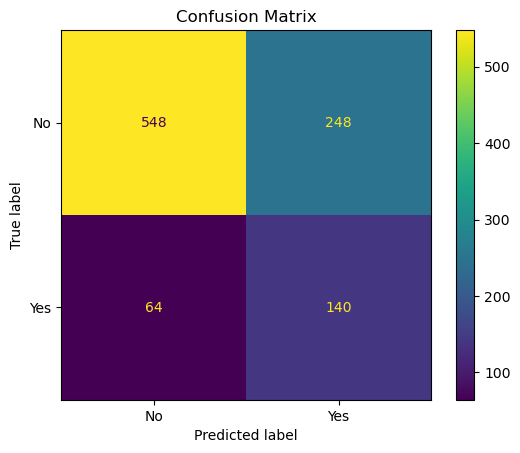

In [106]:
lr = LogisticRegression(C = 0.01,
                        max_iter = 100,
                        penalty = 'l1',
                        solver = 'saga')
print("Logistic Regression Summary:\n")
model_evaluate(lr, X_train_sm, y_train_sm, X_val, y_val)

### 10.4.2. K-Nearest Neighbors

K-Neighbors Classifier Summary:

Train Accuracy: 1.000
Test Accuracy: 0.769
ROC-AUC Score: 0.7482
-------------------------------------------------------

 Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.82      0.85       796
           1       0.45      0.57      0.50       204

    accuracy                           0.77      1000
   macro avg       0.67      0.70      0.68      1000
weighted avg       0.79      0.77      0.78      1000

-------------------------------------------------------


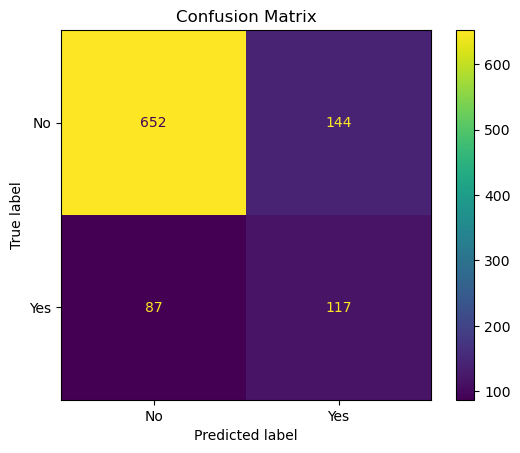

In [107]:
knn = KNeighborsClassifier(metric = 'manhattan',
                           n_neighbors = 3,
                           p = 1,
                           weights = 'distance')
print("K-Neighbors Classifier Summary:\n")
model_evaluate(knn, X_train_sm, y_train_sm, X_val, y_val)

### 10.4.3. Gradient Boosting

Gradient Boosting Classifier Summary:

Train Accuracy: 0.879
Test Accuracy: 0.828
ROC-AUC Score: 0.8494
-------------------------------------------------------

 Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89       796
           1       0.57      0.61      0.59       204

    accuracy                           0.83      1000
   macro avg       0.74      0.75      0.74      1000
weighted avg       0.83      0.83      0.83      1000

-------------------------------------------------------


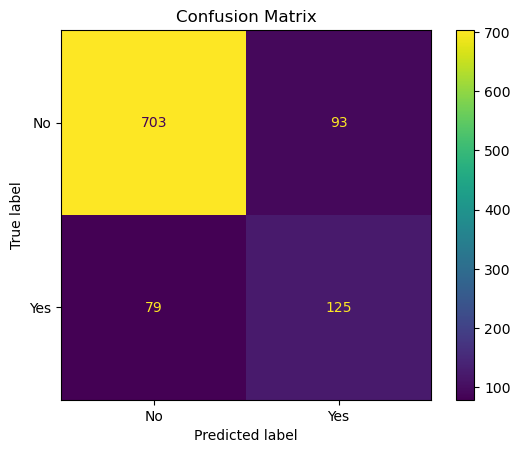

In [108]:
gbc = GradientBoostingClassifier(subsample = 0.5,
                                 n_estimators = 50,
                                 min_samples_split = 10,
                                 min_samples_leaf = 1,
                                 max_features = None,
                                 max_depth = 3,
                                 learning_rate = 0.2)
print("Gradient Boosting Classifier Summary:\n")
model_evaluate(gbc, X_train_sm, y_train_sm, X_val, y_val)

### 10.4.4. XGBoost

XGBoost Classifier Summary:

Train Accuracy: 0.896
Test Accuracy: 0.855
ROC-AUC Score: 0.8617
-------------------------------------------------------

 Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91       796
           1       0.66      0.61      0.63       204

    accuracy                           0.85      1000
   macro avg       0.78      0.76      0.77      1000
weighted avg       0.85      0.85      0.85      1000

-------------------------------------------------------


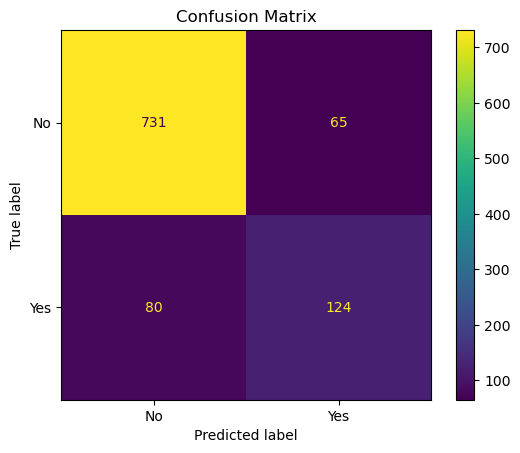

In [109]:
xgb = XGBClassifier(subsample= 0.5,
                    n_estimators = 200,
                    min_child_weight = 1,
                    max_depth = 3,
                    learning_rate = 0.1,
                    gamma = 0.1,
                    colsample_bytree = 0.5)
print("XGBoost Classifier Summary:\n")
model_evaluate(xgb, X_train_sm, y_train_sm, X_val, y_val)

### 10.4.5. Random Forest

Random Forest Classifier Summary:

Train Accuracy: 0.867
Test Accuracy: 0.819
ROC-AUC Score: 0.8500
-------------------------------------------------------

 Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.86      0.88       796
           1       0.55      0.67      0.60       204

    accuracy                           0.82      1000
   macro avg       0.73      0.76      0.74      1000
weighted avg       0.84      0.82      0.83      1000

-------------------------------------------------------


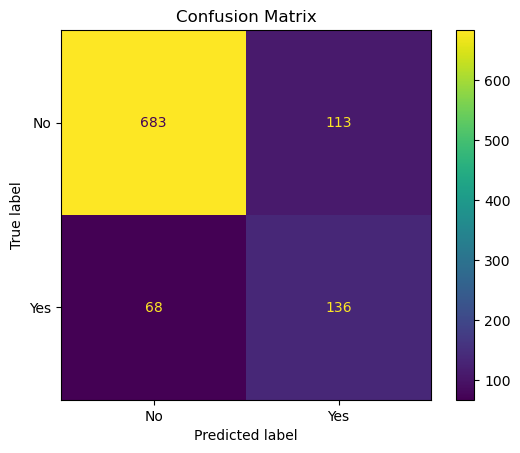

In [110]:
rfc = RandomForestClassifier(n_estimators = 70,
                             max_depth = 8,
                             max_features = 0.75,
                             min_samples_split = 3,
                             random_state = 2)
print("Random Forest Classifier Summary:\n")
model_evaluate(rfc, X_train_sm, y_train_sm, X_val, y_val)

### Comparison of Models

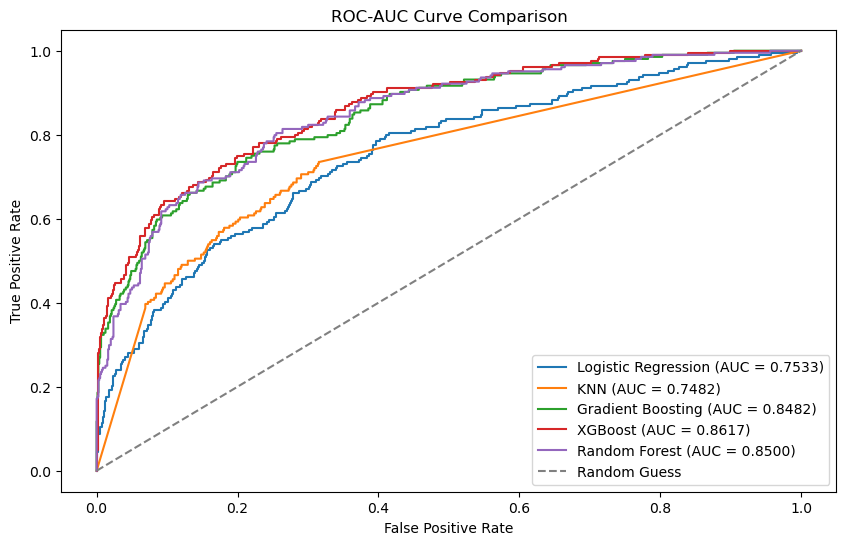

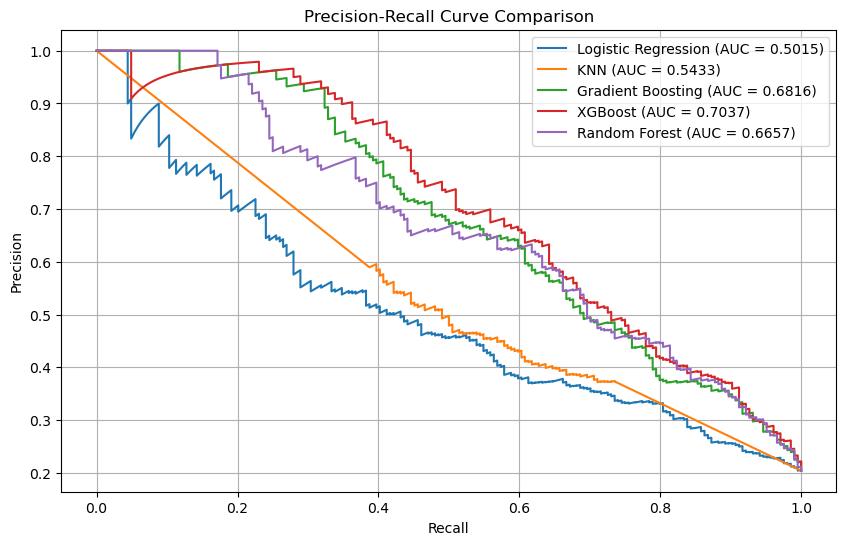

In [111]:
models = {
    "Logistic Regression": lr,
    "KNN": knn,
    "Gradient Boosting": gbc,
    "XGBoost": xgb,
    "Random Forest": rfc    
}

roc_results = {}
pr_results = {}

for name, model in models.items():
    model.fit(X_train_sm, y_train_sm)  # Train model
    y_val_prob = model.predict_proba(X_val)[:, 1]  # Get probability for positive class
    fpr, tpr, _ = roc_curve(y_val, y_val_prob)  # Compute ROC curve
    roc_auc = auc(fpr, tpr)
    roc_results[name] = (fpr, tpr, roc_auc)  # Store results
    
    precisions, recalls, _ = precision_recall_curve(y_val, y_val_prob)  # Compute PR values
    pr_auc = auc(recalls, precisions)  # Compute area under PR curve
    pr_results[name] = (precisions, recalls, pr_auc)  # Store results

plt.figure(figsize=(10,6))
for name, (fpr, tpr, roc_auc) in roc_results.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.4f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")  # Baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve Comparison")
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
for name, (precisions, recalls, pr_auc) in pr_results.items():
    plt.plot(recalls, precisions, label=f"{name} (AUC = {pr_auc:.4f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")
plt.legend()
plt.grid()
plt.show()

**10.4. Model Selection Decision**
- Random Forest, XgBoost and Gradient Boosting perform well on the validation data.
- Since our aim is to improve Recall while keeping enough Precision, we will proceed with Random Forest as it gives the highest Recall with a good overall accuracy.

# 11. Model Evaluation
**Random Forest is our chosen model**

**a. Baseline Random Forest Classifier**

In [112]:
rfc_basic = RandomForestClassifier(random_state = 2)
rfc_basic

RandomForestClassifier(random_state=2)

**b. Best Tuned Model - Random Forest Classifier**

In [113]:
rfc

RandomForestClassifier(max_depth=8, max_features=0.75, min_samples_split=3,
                       n_estimators=70, random_state=2)

Summary for Baseline Model - Random Forest Classifier:

Evaluation on Unseen Test Set (Before Tuning):

Train Accuracy: 1.000
Test Accuracy: 0.855
ROC-AUC Score: 0.8688
-------------------------------------------------------

 Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91       796
           1       0.66      0.60      0.63       204

    accuracy                           0.85      1000
   macro avg       0.78      0.76      0.77      1000
weighted avg       0.85      0.85      0.85      1000

-------------------------------------------------------


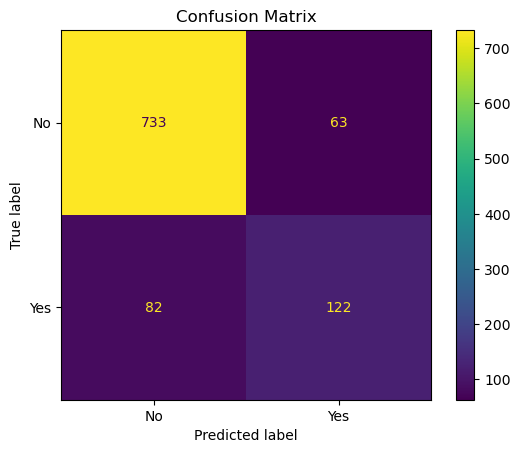

In [114]:
rfc_basic = RandomForestClassifier(random_state = 2)
print("Summary for Baseline Model - Random Forest Classifier:\n")
print('Evaluation on Unseen Test Set (Before Tuning):\n')
model_evaluate(rfc_basic, X_train_sm, y_train_sm, X_test, y_test)

Summary for Best Tuned Model - Random Forest Classifier:

Evaluation on Unseen Test Set (After Tuning):

Train Accuracy: 0.867
Test Accuracy: 0.858
ROC-AUC Score: 0.8828
-------------------------------------------------------

 Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.89      0.91       796
           1       0.63      0.75      0.68       204

    accuracy                           0.86      1000
   macro avg       0.78      0.82      0.80      1000
weighted avg       0.87      0.86      0.86      1000

-------------------------------------------------------


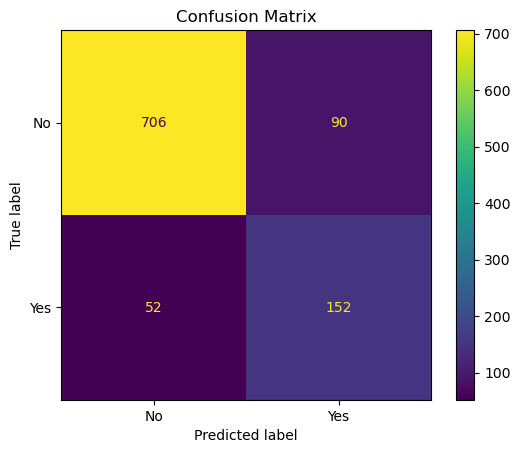

In [115]:
print("Summary for Best Tuned Model - Random Forest Classifier:\n")
print('Evaluation on Unseen Test Set (After Tuning):\n')
model_evaluate(rfc, X_train_sm, y_train_sm, X_test, y_test)

Summary for Best Tuned Model - Random Forest Classifier:

Evaluation on Overall Test Set:

Train Accuracy: 0.867
Test Accuracy: 0.839
ROC-AUC Score: 0.8671
-------------------------------------------------------

 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.87      0.90      1592
           1       0.59      0.71      0.64       408

    accuracy                           0.84      2000
   macro avg       0.75      0.79      0.77      2000
weighted avg       0.85      0.84      0.84      2000

-------------------------------------------------------


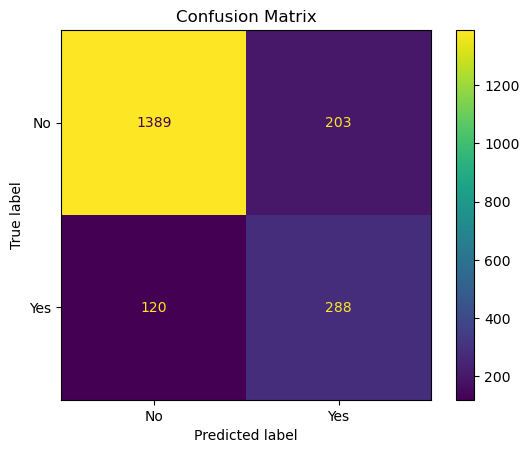

In [116]:
print("Summary for Best Tuned Model - Random Forest Classifier:\n")
print('Evaluation on Overall Test Set:\n')
model_evaluate(rfc, X_train_sm, y_train_sm, X_temp, y_temp)

**11. Interpretation of Results**
- Baseline model summary clearly indicate that the model is Overfitting.
- The model is thus fine tuned using Hyperparameter Tuning (GridSearchCV) to overcome overfitting and to improve performance of the model in terms of Accuracy, Recall and Precision.
- The best tuned model performs well on the validation set as well as the unseen test set, thereby achieving good generalization power.

**Performance Metrics Summary:**

**1. Accuracy**:

    - The model is able to correctly classify 86.7% datapoints of the training data and 85.8% of the unseen test data showcasing good generalization.

**2. Precision:**

    a. Class 0 (Retained Customers): 0.93
    - 93% of the predicted retained customers are actually retained.

    b. Class 1 (Churned Customers): 0.63
    - 63% of the predicted churned customers actually churned.

**3. Recall:**

    a. Class 0 (Retained Customers): 0.89
    - 89% of the retained customers are correctly identified.

    b. Class 1 (Churned Customers): 0.75
    - 75% of the churned customers are correctly identified.

**4. F1**

    a. Class 0 (Retained Customers): 0.91
    - The model is correctly identifying 91% of the retained customers with high Precision and Recall.

    b. Class 1 (Churned Customers): 0.68
    - The model correctly identifies 68% of the churned instances and misses the other due to imbalanced distribution of churned instances.

**5. Macro Avg**

    - Describes average performance of both the churned and retained classes assigning equal weightage to each class.
    - Precision (0.78), Recall (0.82) and F1 (0.80)

**6. Weighted Avg**

    - Describes weighted average performance of both the churned and retained classes by taking into account the distribution of classes.
    - Precision (0.87), Recall (0.86) and F1 (0.86)

Baseline Model - ROC-AUC: 0.8688
Baseline Model - PR: 0.6849

Best Tuned Model - Validation ROC-AUC: 0.8500
Best Tuned Model - Test ROC-AUC: 0.8828

Best Tuned Model - Validation PR: 0.6657
Best Tuned Model - Test PR: 0.7189



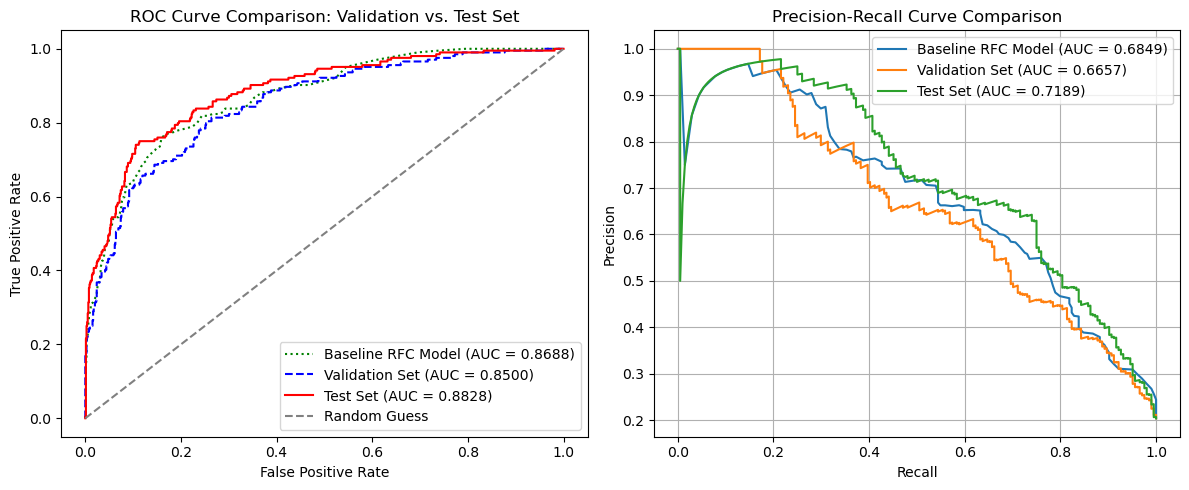

In [117]:
y_probs = rfc_basic.predict_proba(X_test)[:, 1]
y_val_probs = rfc.predict_proba(X_val)[:, 1]
y_test_probs = rfc.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds_roc = roc_curve(y_test, y_probs)
fpr_val, tpr_val, thresholds_val_roc = roc_curve(y_val, y_val_probs)
fpr_test, tpr_test, thresholds_test_roc = roc_curve(y_test, y_test_probs)

roc_auc = auc(fpr, tpr)
roc_auc_val = auc(fpr_val, tpr_val)
roc_auc_test = auc(fpr_test, tpr_test)

precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_probs) 
precisions_val, recalls_val, thresholds_val_pr = precision_recall_curve(y_val, y_val_probs)  # Compute PR values
precisions_test, recalls_test, thresholds_test_pr = precision_recall_curve(y_test, y_test_probs)

pr_auc = auc(recalls, precisions)
pr_auc_val = auc(recalls_val, precisions_val)
pr_auc_test = auc(recalls_test, precisions_test)

print(f"Baseline Model - ROC-AUC: {roc_auc:.4f}")
print(f"Baseline Model - PR: {pr_auc:.4f}\n")
print(f"Best Tuned Model - Validation ROC-AUC: {roc_auc_val:.4f}")
print(f"Best Tuned Model - Test ROC-AUC: {roc_auc_test:.4f}\n")
print(f"Best Tuned Model - Validation PR: {pr_auc_val:.4f}")
print(f"Best Tuned Model - Test PR: {pr_auc_test:.4f}\n")

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"Baseline RFC Model (AUC = {roc_auc:.4f})", linestyle=":", color="green")
plt.plot(fpr_val, tpr_val, label=f"Validation Set (AUC = {roc_auc_val:.4f})", linestyle="--", color="blue")
plt.plot(fpr_test, tpr_test, label=f"Test Set (AUC = {roc_auc_test:.4f})", linestyle="-", color="red")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison: Validation vs. Test Set")
plt.legend()

plt.subplot(1,2,2)
plt.plot(recalls, precisions, label = f"Baseline RFC Model (AUC = {pr_auc:0.4f})")
plt.plot(recalls_val, precisions_val, label=f"Validation Set (AUC = {pr_auc_val:.4f})")
plt.plot(recalls_test, precisions_test, label=f"Test Set (AUC = {pr_auc_test:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

**Interpretation of ROC Curve and Precision-Recall Curve**
- ROC curve represents relationship between True Positive Rate (Benefit) vs False Positive Rate (Cost) for different threshold values.
- The AUC-ROC score of 0.8828 for the best-tuned model suggests that the model has a strong ability to effectively distinguish between customers who churn and those who don't.
- The AUC-PR score of 0.7189 suggests that the model has moderate yet decent performance in capturing the cases of positive instances (Churners).

### Feature Importance

In [118]:
feature_imp = rfc.feature_importances_
df_feature_imp = (
    pd.DataFrame(
        data = feature_imp*100,
        index = X_train_df.columns,
        columns = ['Importance(%)']
    )
    .rename_axis('Features')
    .reset_index()
    .sort_values(
        by = ['Importance(%)'],
        ascending = False,
        ignore_index = True
    )
)
display(df_feature_imp)

,Features,Importance(%)
0,Age_Log,41.185546
1,NumOfProducts,19.509979
2,HasCrCard_Yes,12.070104
3,Geography_Germany,8.076123
4,Balance,7.916718
5,Gender_Male,4.826888
6,EstimatedSalary,2.210489
7,Tenure,1.954126
8,CreditScore,1.616141
9,Geography_Spain,0.633886


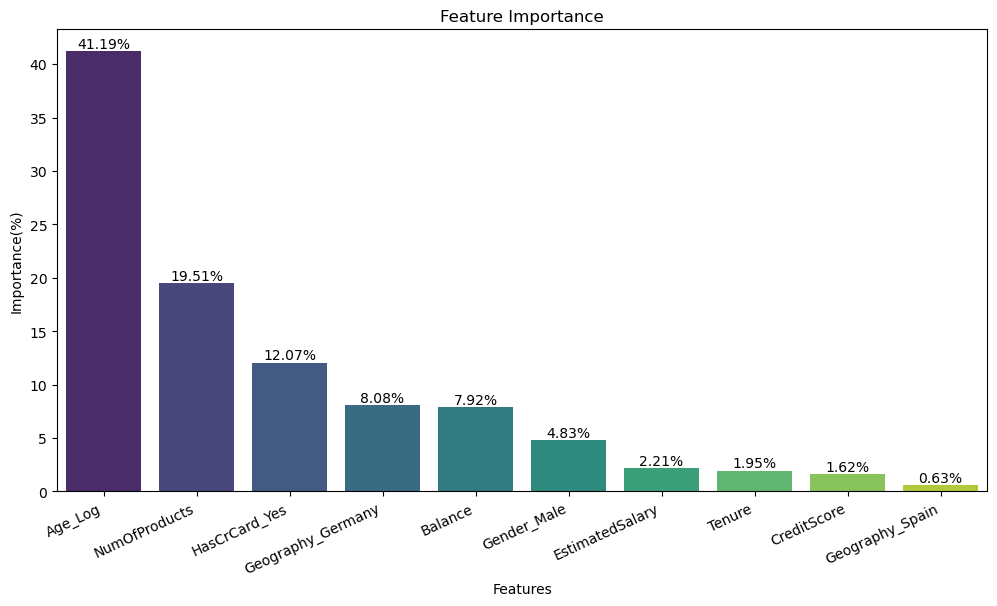

In [119]:
plt.figure(figsize = (12,6))
ax = sns.barplot(data = df_feature_imp, x = 'Features', y = 'Importance(%)', palette = 'viridis')
for bar in ax.containers:
    ax.bar_label(bar, labels = [f'{label.get_height():0.2f}%' for label in bar])
plt.xticks(rotation = 25, ha = 'right')
plt.title('Feature Importance')
plt.show()

**Interpretation of Feature Importances**
- As per our model, 'Age' plays a crucial role in deciding whether a particular customer will exit a Bank or not.
- Number of products is second most important feature with a score of 19.51%, followed by 'HasCrCard' feature (12.07%).
- Country, Balance and Gender are also important features that contribute in the prediction of churn.

# 12. Conclusion

- A Machine Learning model is built for Bank Churn prediction using Random Forest Classifier. 
- We have analyzed various demographic factors like Age, Gender, Country and financial factors like Credit Score, Salary, Balance, Credit Card, Number of Products, Tenure and studied its effect on the likelihood of churn.
- As per the dataset, key factors that influence churn are Age, Products with Bank, possession of Credit Card, Balance, Country and the Gender of the customer.
- The overall performance of the model is well.

Summary:

1. Good generalization with a high Accuracy of 86% on the chunk of unseen test data and about 84% on the overall unseen test data.
      
2. Good Recall for Churners (75%) indicating that the churned customers are identified well enough while balancing the Precision score.

3. AUC-ROC score of 0.8828 suggests models ability to effectively differentiate between churned customers and the retained customers.

4. PR-AUC of 0.7189 showcases the moderate balance between Precision and the Recall while capturing the cases of Churned customers.

Using the models predictive power, Bank can proactively identify customers that are at the risk of leaving, enabling it to prioritize strategies for customer retention and thereby maximizing the revenue.

# 13. Recommendations

**A. Strategies for impactful features**

*Insights*:
1. *Age*: Older customers are more likely to churn
2. *Geography*: Customers from a low customer base country (Germany) are more likely to churn
3. *Gender*: Feamle customers tend to leave banks at higher rate
4. *Active Member/ Credit Card*: Inactive customers or those with no Credit Cards churn more
5. *Number of Products*: Though less in number, customers with 3 or 4 products churn at higher rate
6. *Balance*: Customers maintaining high balance are churned in high numbers

Any combination of the above features increases the chances of churning.

*Recommendations*:
- Bank may focus on personalized engagement for older customers by offering retirement plans and investment plans.
- Providing door step financial services to senior citizens and proper timely feedback mechanism can enhance customer relationship.
- Bank must prioritize improving services even at the location with small customer base and plan special loyalty programs and perks to retain customers in the region of higher churn rates.
- Gender specific programs to be initiated to enhance banking experiences for female customers like - literacy programs, investment schemes tailored to women.
- Re-engagement campaigns to be launched to re-activate the customers by offering attractive services including digital marketing and banking.
- Engage customers by offering them Credit Cards with perks and competitive rates.
- Bank must also check on the products as to why customers churned even with higher products usage and try to mitigate the issue by offering strong customer support.
- Customers who exited with high balances in the account must be analyzed further to get more insights.

**B. Strategies for less important features**
- Credit Scores, Estimated Salary and Tenure showed minimal impact on the churn.
- Bank must analyze the behavior of these features and try to study their interactions with other features to improve the predictive power.

**General**

- In general, alongwith re-connect campaigns, Bank must opt for Customer Retention programs which are demographic specific (age, gender and region). That is, try segementing customers in order to offer services and products as per their needs.